#### General imports

In [2]:
import pandas as pd
from pandas import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# fix random seed for consistent colour generation
np.random.seed(0)

### Prepare locations

#### Load location history dataset

In [4]:
import json
import glob # for enumerating over files in a directory

def set_row_with_activity_segment_base_features(row, activity_segment):
    row['start_location_longitude'] = activity_segment['startLocation']['longitudeE7'] \
        if 'longitudeE7' in activity_segment['startLocation'].keys() else None
    row['start_location_latitude'] = activity_segment['startLocation']['latitudeE7'] \
        if 'latitudeE7' in activity_segment['startLocation'].keys() else None
    row['end_location_longitude'] = activity_segment['endLocation']['longitudeE7'] \
        if 'longitudeE7' in activity_segment['endLocation'].keys() else None
    row['end_location_latitude'] = activity_segment['endLocation']['latitudeE7'] \
        if 'latitudeE7' in activity_segment['endLocation'].keys() else None
    
    row['start_time'] = activity_segment['duration']['startTimestamp']
    row['end_time'] = activity_segment['duration']['endTimestamp']
    row['distance'] = activity_segment['distance'] \
        if 'distance' in activity_segment.keys() else None
    row['activity_type'] = activity_segment['activityType'] \
        if 'activityType' in activity_segment.keys() else None
    row['activity_type_confidence'] = activity_segment['confidence'] \
        if 'confidence' in activity_segment.keys() else None

def set_row_with_start_place_base_features(row, previous_segment):
    if not previous_segment or not 'placeVisit' in previous_segment.keys():
        return
    place_visit_segment = previous_segment['placeVisit']
    row['start_place_start_time'] = place_visit_segment['duration']['startTimestamp']
    row['start_place_end_time'] = place_visit_segment['duration']['endTimestamp']
    row['start_place_confidence'] = place_visit_segment['placeConfidence'] \
        if 'placeConfidence' in place_visit_segment.keys() else None
    row['start_place_semantic_type'] = place_visit_segment['location']['semanticType'] \
        if 'semanticType' in place_visit_segment['location'].keys() else None

def set_row_with_end_place_base_features(row, next_segment):
    if not next_segment or not 'placeVisit' in next_segment.keys():
        return
    place_visit_segment = next_segment['placeVisit']
    row['end_place_start_time'] = place_visit_segment['duration']['startTimestamp']
    row['end_place_end_time'] = place_visit_segment['duration']['endTimestamp']
    row['end_place_confidence'] = place_visit_segment['placeConfidence'] \
        if 'placeConfidence' in place_visit_segment.keys() else None
    row['end_place_semantic_type'] = place_visit_segment['location']['semanticType'] \
        if 'semanticType' in place_visit_segment['location'].keys() else None

def build_activity_row(segment_index, activity_segment, all_segments):
    previous_segment = all_segments[segment_index - 1] if segment_index > 0 else None
    next_segment = all_segments[segment_index + 1] if segment_index < len(all_segments) - 1 else None
    row = {}
    set_row_with_activity_segment_base_features(row, activity_segment)
    set_row_with_start_place_base_features(row, previous_segment)
    set_row_with_end_place_base_features(row, next_segment)
    return row

def build_activity_rows_from_dataset(dataset_filename):
    with open(dataset_filename, encoding="utf8") as dataset_file:
        locations_dataset = json.load(dataset_file)
    segments = locations_dataset['timelineObjects']
    return [
        build_activity_row(segment_index, segment['activitySegment'], segments) 
        for segment_index, segment in enumerate(segments) 
        if 'activitySegment' in segment.keys()]
 
def build_activity_rows_for_all_dataset_files():
    return [activity_row 
        for filename in glob.iglob(f'Semantic Location History/*/*.json')
        for activity_row in build_activity_rows_from_dataset(filename)]

raw_activity_rows = build_activity_rows_for_all_dataset_files()
activity_frame = pd.DataFrame(raw_activity_rows)
activity_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16234 entries, 0 to 16233
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   start_location_longitude   14708 non-null  float64
 1   start_location_latitude    14708 non-null  float64
 2   end_location_longitude     14708 non-null  float64
 3   end_location_latitude      14708 non-null  float64
 4   start_time                 16234 non-null  object 
 5   end_time                   16234 non-null  object 
 6   distance                   14249 non-null  float64
 7   activity_type              12026 non-null  object 
 8   activity_type_confidence   16046 non-null  object 
 9   end_place_start_time       12396 non-null  object 
 10  end_place_end_time         12396 non-null  object 
 11  end_place_confidence       12156 non-null  object 
 12  end_place_semantic_type    4705 non-null   object 
 13  start_place_start_time     12298 non-null  obj

#### Cleanse nulls

Inspect columns for null quantities:

In [5]:
null_count = activity_frame.isnull().sum()
nulls_frame = pd.DataFrame({'null_count': null_count, 'null_percent': null_count * 100 / len(activity_frame)})
nulls_frame

,null_count,null_percent
start_location_longitude,1526,9.400025
start_location_latitude,1526,9.400025
end_location_longitude,1526,9.400025
end_location_latitude,1526,9.400025
start_time,0,0.000000
end_time,0,0.000000
distance,1985,12.227424
activity_type,4208,25.920907
activity_type_confidence,188,1.158063
end_place_start_time,3838,23.641740


Visualise nulls over time to see correlations, to help decide between dropping or imputing nulls 

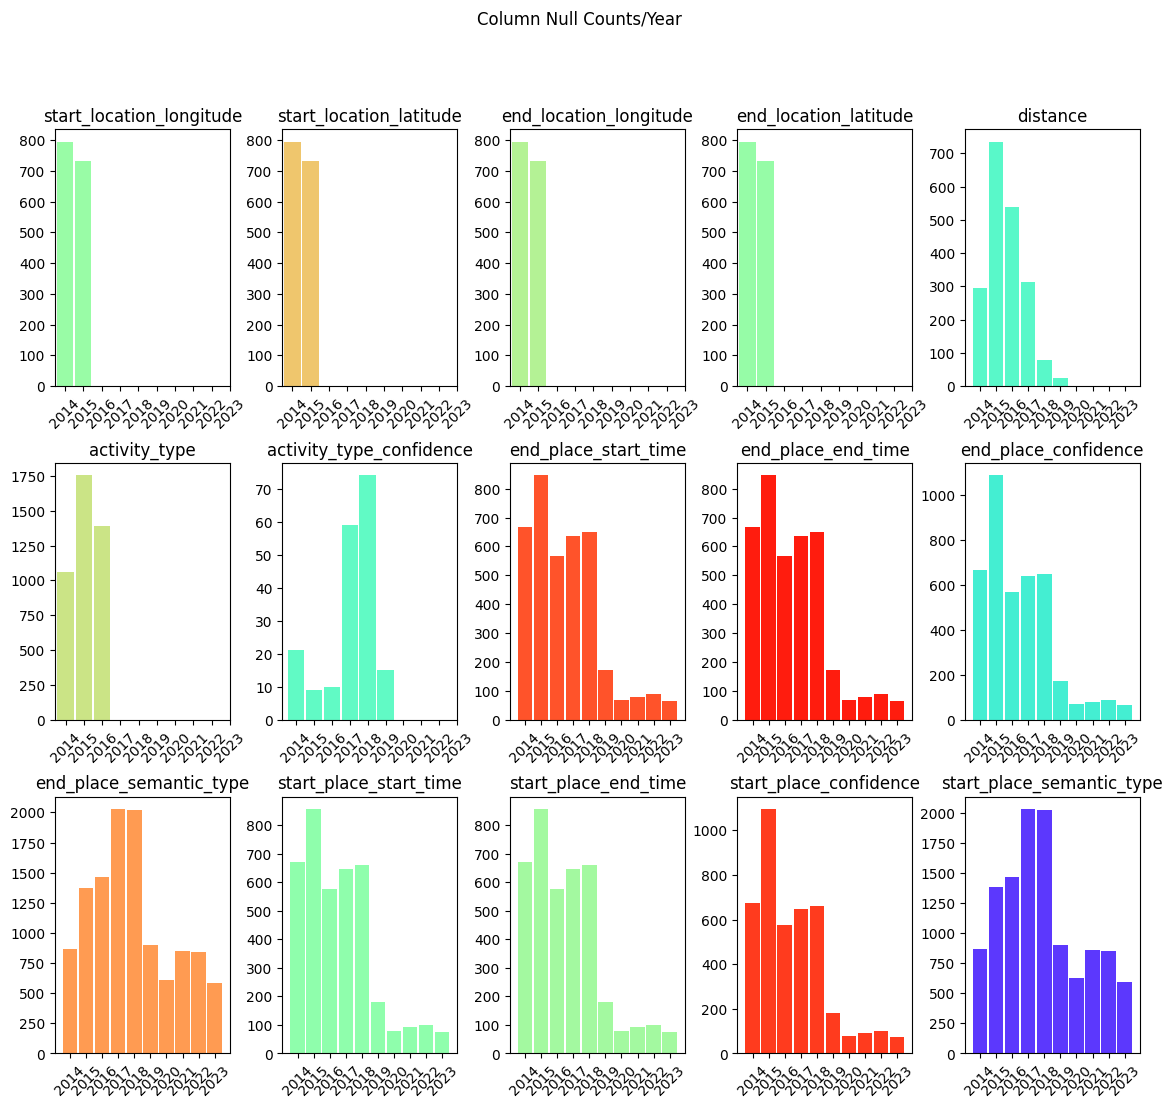

In [6]:
def plot_column_nulls_per_year(column_name, activity_with_years_frame, ax, all_years):
    null_columns_by_years_frame = activity_with_years_frame[activity_with_years_frame[column_name].isnull() == True]['year'] \
        .groupby(activity_with_years_frame['year']).count()
    ax.bar(null_columns_by_years_frame.index, 
           null_columns_by_years_frame.values, 
           align='center', 
           width=0.9, 
           color=plt.cm.rainbow(np.random.rand(1)))
    ax.set_xticks(all_years)
    ax.set_xticklabels(all_years, rotation=45)
    ax.set_title(column_name)

def plot_columns_with_nulls_per_year():
    fig, axes = plt.subplots(3, 5, figsize=(14,12))
    names_of_columns_with_nulls = nulls_frame[nulls_frame['null_count'] > 0].index

    # using the 'start_time' column years to plot in place of nulls, as it's a known complete column, and is easy to group by
    activity_with_years_frame = activity_frame.copy()
    activity_with_years_frame['year'] = activity_with_years_frame['start_time'].str[:4].astype(int)
    all_years = activity_with_years_frame['year'].unique()

    for index, column_name in enumerate(names_of_columns_with_nulls):
        ax = axes[index//5][index%5]
        plot_column_nulls_per_year(column_name, activity_with_years_frame, ax, all_years)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    fig.suptitle('Column Null Counts/Year')
    plt.show()

plot_columns_with_nulls_per_year()

Impute/drop actions per column:

- Longitude/latitude columns: Dropping these rows, as these are key features for analysis, and is incomplete data
- Distance: Dropping nulls as it is also a sign of incomplete older data, and is a key to the concept of transit 
- Activity type: This is a fundamental feature, so dropping nulls
- Confidence: Imputing this as 'LOW' confidence
- Start/end place start/end times: This was intended for integrity cross checks against activity start/end times, so will be imputed. Impute based on mean start to end time.
- Start/end place confidences: Imputing this as low confidence
- Start/end place semantic types: Imputing this as unknown type

In [7]:
def handle_column_nulls():
    activity_frame.dropna(subset=[
            'start_location_longitude', 
            'start_location_latitude', 
            'end_location_longitude',
            'end_location_latitude',
            'distance',
            'activity_type'
        ], inplace=True)

    activity_frame['activity_type_confidence'].fillna('LOW', inplace=True)
    activity_frame['start_place_end_time'].fillna(activity_frame['start_time'], inplace=True)
    activity_frame['end_place_start_time'].fillna(activity_frame['end_time'], inplace=True)
    activity_frame['start_place_confidence'].fillna('LOW_CONFIDENCE', inplace=True)
    activity_frame['end_place_confidence'].fillna('LOW_CONFIDENCE', inplace=True)
    activity_frame['start_place_semantic_type'].fillna('UNKNOWN', inplace=True)
    activity_frame['end_place_semantic_type'].fillna('UNKNOWN', inplace=True)

handle_column_nulls()

A more complex case is the place times farthest from the activity, in order to calculate the imputed values we need to know the mean durations of the place times. First we first get some spot check indexes to verify imputation on:

In [8]:
example_null_place_indexes = activity_frame[activity_frame['start_place_start_time'].isnull()].head(5).index
activity_frame.loc[example_null_place_indexes][['start_place_start_time', 'start_place_end_time']]

,start_place_start_time,start_place_end_time
77,NaN,2014-08-09T10:54:36.840Z
449,NaN,2014-07-26T09:51:10.301Z
1245,NaN,2015-08-03T07:50:05.445Z
1313,NaN,2015-08-13T07:49:09.363Z
1337,NaN,2015-08-18T07:44:41.718Z


Then we impute the times based on means (not this requires some datetime column conversions for computation):

In [10]:
def convert_place_time_columns_to_datetime():
    activity_frame['start_place_start_time'] = pd.to_datetime(activity_frame['start_place_start_time'], format='ISO8601')
    activity_frame['start_place_end_time'] = pd.to_datetime(activity_frame['start_place_end_time'], format='ISO8601')
    activity_frame['end_place_start_time'] = pd.to_datetime(activity_frame['end_place_start_time'], format='ISO8601')
    activity_frame['end_place_end_time'] = pd.to_datetime(activity_frame['end_place_end_time'], format='ISO8601') 

def determine_means_of_place_durations():
    convert_place_time_columns_to_datetime()
    activity_frame['start_place_duration'] = activity_frame['start_place_end_time'] - activity_frame['start_place_start_time']
    activity_frame['end_place_duration'] = activity_frame['end_place_end_time'] - activity_frame['end_place_start_time']
    return activity_frame['start_place_duration'].mean(), activity_frame['end_place_duration'].mean()

def impute_mean_extrapolated_place_times(mean_start_place_duration, mean_end_place_duration):
    activity_frame['start_place_start_time'].fillna(activity_frame['start_place_end_time'] - mean_start_place_duration, inplace=True) 
    activity_frame['end_place_end_time'].fillna(activity_frame['end_place_start_time'] + mean_end_place_duration, inplace=True)
    # refresh durations for completeness after imputing
    activity_frame['start_place_duration'] = activity_frame['start_place_end_time'] - activity_frame['start_place_start_time']
    activity_frame['end_place_duration'] = activity_frame['end_place_end_time'] - activity_frame['end_place_start_time']

mean_start_place_duration, mean_end_place_duration = determine_means_of_place_durations()
print(f'Mean start place duration: {mean_start_place_duration}, mean end place duration: {mean_end_place_duration}')

impute_mean_extrapolated_place_times(mean_start_place_duration, mean_end_place_duration)
activity_frame.loc[example_null_place_indexes][['start_place_start_time', 'start_place_end_time']]

Mean start place duration: 0 days 05:00:09.138189462, mean end place duration: 0 days 05:19:19.108574307


,start_place_start_time,start_place_end_time
77,2014-08-09 05:54:27.701810538+00:00,2014-08-09 10:54:36.840000+00:00
449,2014-07-26 04:51:01.162810538+00:00,2014-07-26 09:51:10.301000+00:00
1245,2015-08-03 02:49:56.306810538+00:00,2015-08-03 07:50:05.445000+00:00
1313,2015-08-13 02:49:00.224810538+00:00,2015-08-13 07:49:09.363000+00:00
1337,2015-08-18 02:44:32.579810538+00:00,2015-08-18 07:44:41.718000+00:00


#### Cleanse low confidence data

Visualise all categories:

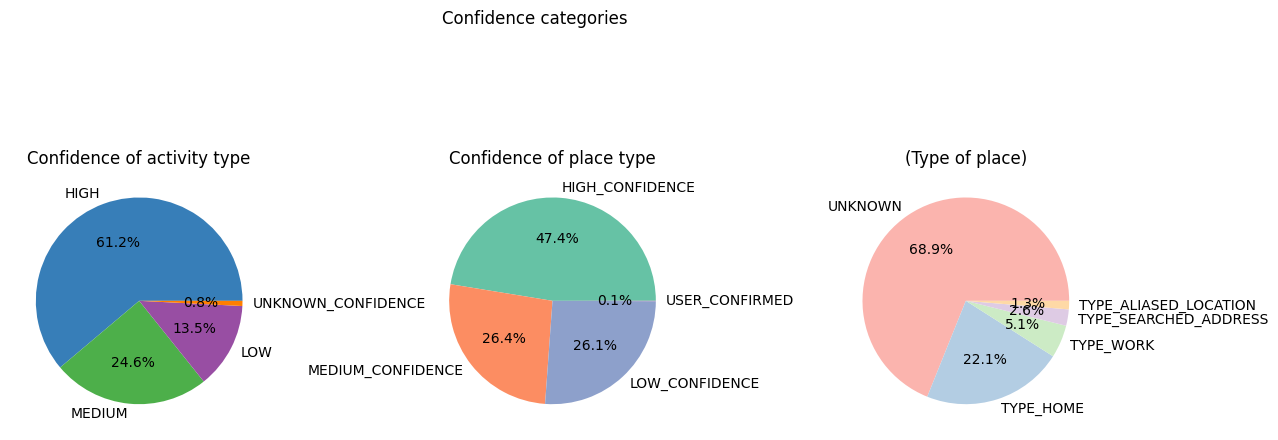

In [11]:
def plot_confidence_pie(ax, column_name, title, colours):
    confidence_series = activity_frame[column_name]
    ax.pie(confidence_series.value_counts(), 
        labels=confidence_series.value_counts().index, 
        autopct='%1.1f%%', 
        colors=colours)
    ax.set_title(title)

def plot_confidence_pies():
    fig, axes = plt.subplots(1, 3, figsize=(14,6))
    plot_confidence_pie(axes[0], 'activity_type_confidence', 'Confidence of activity type', plt.cm.Set1(np.arange(1,5)))
    plot_confidence_pie(axes[1], 'start_place_confidence', 'Confidence of place type', plt.cm.Set2(np.arange(4)))
    plot_confidence_pie(axes[2], 'start_place_semantic_type', '(Type of place)', plt.cm.Pastel1(np.arange(5)))
    fig.suptitle('Confidence categories')
    fig.subplots_adjust(wspace=0.6)
    plt.show()
    
plot_confidence_pies()

Drop all activity rows other than high/medium confidence, and impute all place semantic types to UNKNOWN other than high/medium confidence, then finally having applied the confidence columns to the frame, we can now drop the confidence columns:

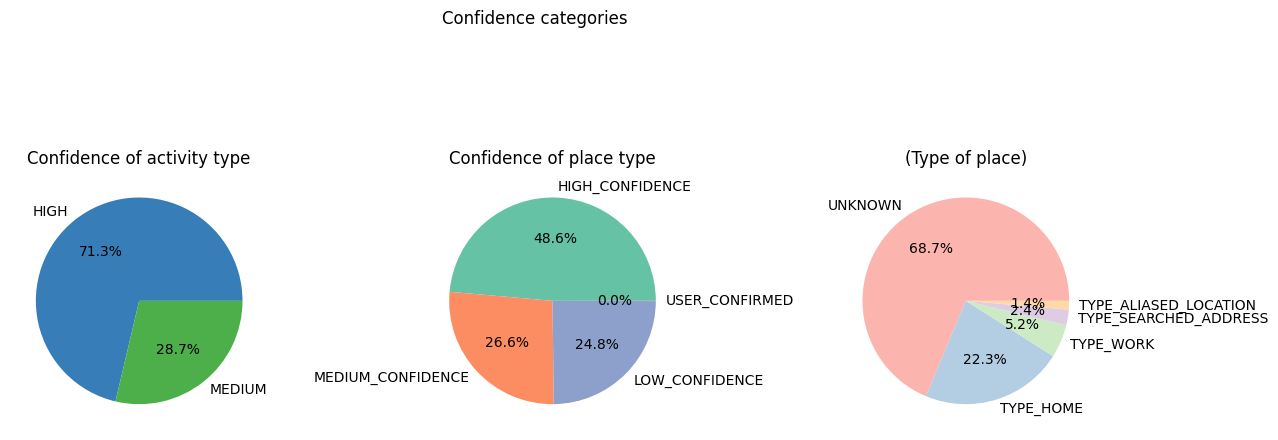

In [12]:
def handle_low_confidences(activity_frame):
    acceptable_confidences = ['HIGH', 'MEDIUM', 'HIGH_CONFIDENCE', 'MEDIUM_CONFIDENCE']
    activity_frame = activity_frame[activity_frame['activity_type_confidence'].isin(acceptable_confidences)]
    activity_frame.loc[~activity_frame['start_place_confidence'].isin(acceptable_confidences), 'start_place_semantic_type'] = 'UNKNOWN'
    activity_frame.loc[~activity_frame['end_place_confidence'].isin(acceptable_confidences), 'end_place_semantic_type'] = 'UNKNOWN'
    return activity_frame
    
activity_frame = handle_low_confidences(activity_frame)
plot_confidence_pies()
activity_frame.drop(columns=['activity_type_confidence', 'start_place_confidence', 'end_place_confidence'], inplace=True)

#### Reduce categorical features

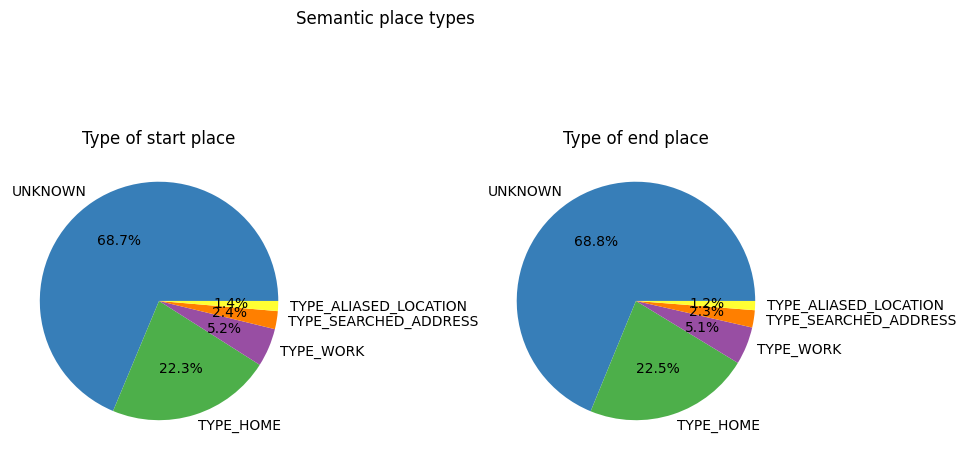

In [13]:
def plot_semantic_type(ax, column_name, title):
    semantic_type_series = activity_frame[column_name]
    ax.pie(semantic_type_series.value_counts(), 
        labels=semantic_type_series.value_counts().index, 
        autopct='%1.1f%%', 
        colors=plt.cm.Set1(np.arange(1,6)))
    ax.set_title(title)

def plot_semantic_types():
    fig, axes = plt.subplots(1, 2, figsize=(10,6))
    plot_semantic_type(axes[0], 'start_place_semantic_type', 'Type of start place')
    plot_semantic_type(axes[1], 'end_place_semantic_type', 'Type of end place')
    fig.suptitle('Semantic place types')
    fig.subplots_adjust(wspace=0.6)
    plt.show()
    
plot_semantic_types()

Only work and home are useful, so bucket the rest as OTHER:

Note: start and end places are expected to be identical as they are almost identical sources. One being the prior place the other being the following place from activity, but as the activity segments are were initially in a zip structure with place segments, they are shared between sequential activities. The difference is a result of dropped rows, and the edge case of first and last activity in dataset file

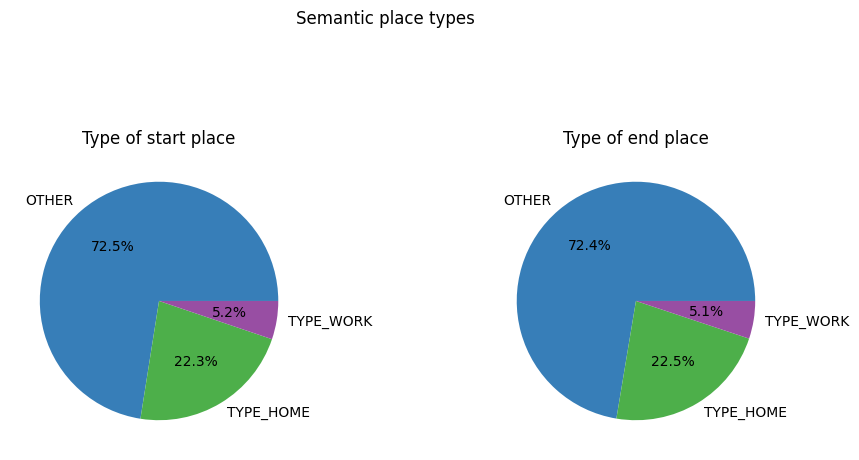

In [14]:
activity_frame.loc[~activity_frame['start_place_semantic_type'].isin(['TYPE_WORK', 'TYPE_HOME']), 'start_place_semantic_type'] = 'OTHER'
activity_frame.loc[~activity_frame['end_place_semantic_type'].isin(['TYPE_WORK', 'TYPE_HOME']), 'end_place_semantic_type'] = 'OTHER'
plot_semantic_types()

As show below activity types were already cleaned of unknowns as a result of confidence based cleaning, so no further actions are required:

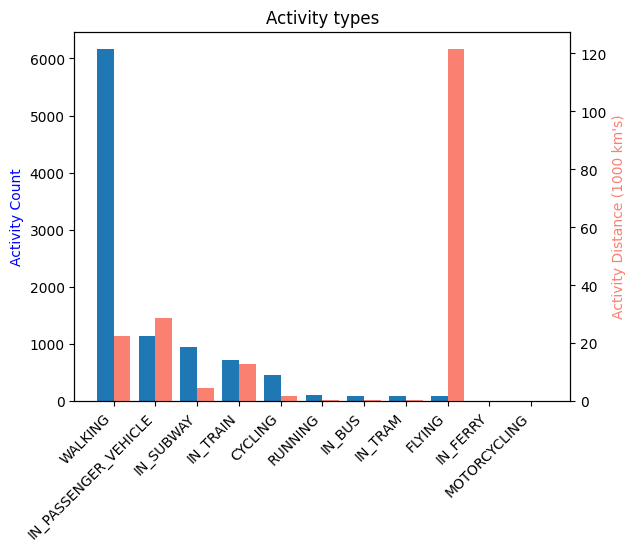

In [15]:
def plot_activity_types():
    activity_type_groups = build_activity_type_groups()
    ax = plt.subplot()
    ax.bar(activity_type_groups.index-0.2, activity_type_groups['count'], width=0.4)
    ax.set_ylabel('Activity Count', color='blue')
    ax.set_xticks(activity_type_groups.index)
    ax.set_xticklabels(activity_type_groups['activity_type'], rotation=45, ha='right')
    ax.set_title('Activity types')
    ax_twin = ax.twinx()
    ax_twin.bar(activity_type_groups.index+0.2, activity_type_groups['distance'], width=0.4, color='salmon')
    ax_twin.set_ylabel('Activity Distance (1000 km\'s)', color='salmon')
    plt.show()

def build_activity_type_groups():
    activity_type_groups = activity_frame.groupby('activity_type') \
        .agg({'activity_type': 'count', 'distance': 'sum'})
    activity_type_groups['distance'] = activity_type_groups['distance'] / 1000000
    activity_type_groups = activity_type_groups.rename(columns={'activity_type': 'count'})
    activity_type_groups = activity_type_groups.sort_values(by='count', ascending=False)
    activity_type_groups['activity_type'] = activity_type_groups.index
    activity_type_groups.reset_index(drop=True, inplace=True)
    return activity_type_groups

plot_activity_types()

#### Transform features' formats

In [16]:
activity_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9835 entries, 1245 to 16231
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   start_location_longitude   9835 non-null   float64            
 1   start_location_latitude    9835 non-null   float64            
 2   end_location_longitude     9835 non-null   float64            
 3   end_location_latitude      9835 non-null   float64            
 4   start_time                 9835 non-null   object             
 5   end_time                   9835 non-null   object             
 6   distance                   9835 non-null   float64            
 7   activity_type              9835 non-null   object             
 8   end_place_start_time       9835 non-null   datetime64[ns, UTC]
 9   end_place_end_time         9835 non-null   datetime64[ns, UTC]
 10  end_place_semantic_type    9835 non-null   object             
 11  start

The identified `object` types need conversion:

In [17]:
def define_column_types():
    categorical_activity_type = CategoricalDtype(categories=activity_frame['activity_type'].unique())
    place_sematic_types = set(activity_frame['start_place_semantic_type'].unique()).union({'OTHER'})
    categorical_place_semantic_type = CategoricalDtype(categories=place_sematic_types)
    return categorical_activity_type, categorical_place_semantic_type

def transform_data_types(categorical_activity_type, categorical_place_semantic_type):
    activity_frame['start_time'] = pd.to_datetime(activity_frame['start_time'], format='ISO8601')
    activity_frame['end_time'] = pd.to_datetime(activity_frame['end_time'], format='ISO8601')
    activity_frame['activity_type'] = activity_frame['activity_type'].astype(categorical_activity_type)
    activity_frame['start_place_semantic_type'] = activity_frame['start_place_semantic_type'].astype(categorical_place_semantic_type)
    activity_frame['end_place_semantic_type'] = activity_frame['end_place_semantic_type'].astype(categorical_place_semantic_type)
    
categorical_activity_type, categorical_place_semantic_type = define_column_types()
transform_data_types(categorical_activity_type, categorical_place_semantic_type)
activity_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9835 entries, 1245 to 16231
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   start_location_longitude   9835 non-null   float64            
 1   start_location_latitude    9835 non-null   float64            
 2   end_location_longitude     9835 non-null   float64            
 3   end_location_latitude      9835 non-null   float64            
 4   start_time                 9835 non-null   datetime64[ns, UTC]
 5   end_time                   9835 non-null   datetime64[ns, UTC]
 6   distance                   9835 non-null   float64            
 7   activity_type              9835 non-null   category           
 8   end_place_start_time       9835 non-null   datetime64[ns, UTC]
 9   end_place_end_time         9835 non-null   datetime64[ns, UTC]
 10  end_place_semantic_type    9835 non-null   category           
 11  start

We also need to transform locations from Google E7 format to standard longitude/latitude, for which we first get some examples for later success verification:

In [18]:
example_locations = activity_frame.head(5).index
activity_frame.loc[example_locations][['start_location_longitude', 'start_location_latitude']]

,start_location_longitude,start_location_latitude
1245,-1909282.0,515466852.0
1313,-1798917.0,515469510.0
1337,-1798917.0,515469510.0
1339,-1439184.0,515237421.0
1344,-1909282.0,515466852.0


Transform locations and verify:

In [19]:
def map_location_e7_to_degrees(location_e7):
    """location_e7: E7 format is Google's integer lat/long format"""
    return location_e7 / 10**7

def transform_location_columns_to_degrees():
    activity_frame['start_location_longitude'] = activity_frame['start_location_longitude'].apply(map_location_e7_to_degrees)
    activity_frame['start_location_latitude'] = activity_frame['start_location_latitude'].apply(map_location_e7_to_degrees)
    activity_frame['end_location_longitude'] = activity_frame['end_location_longitude'].apply(map_location_e7_to_degrees)
    activity_frame['end_location_latitude'] = activity_frame['end_location_latitude'].apply(map_location_e7_to_degrees)

transform_location_columns_to_degrees()
activity_frame.loc[example_locations][['start_location_longitude', 'start_location_latitude']]

,start_location_longitude,start_location_latitude
1245,-0.190928,51.546685
1313,-0.179892,51.546951
1337,-0.179892,51.546951
1339,-0.143918,51.523742
1344,-0.190928,51.546685


#### Check integrity

Check that the start and end places associated to activities are adjacent:

In [20]:
start_place_integrity_frame = activity_frame[activity_frame['start_place_end_time'] != activity_frame['start_time']]
end_place_integrity_frame = activity_frame[activity_frame['end_place_start_time'] != activity_frame['end_time']]
print('Start place integrity row count: ', len(start_place_integrity_frame))
print('End place integrity row count: ', len(end_place_integrity_frame))

Start place integrity row count:  20
End place integrity row count:  36


The place time integrity checks reveals some anomalies in places, possibly due to missing data segments, which due to the low quantity can be imputed to a place of UNKNOWN, and a duration of mean:

In [21]:
def handle_integrity_failures():
    activity_frame.loc[start_place_integrity_frame.index, 'start_place_semantic_type'] = 'OTHER'
    activity_frame.loc[start_place_integrity_frame.index, 'start_place_duration'] = mean_start_place_duration
    activity_frame.loc[end_place_integrity_frame.index, 'end_place_semantic_type'] = 'OTHER'
    activity_frame.loc[end_place_integrity_frame.index, 'end_place_duration'] = mean_end_place_duration

handle_integrity_failures()
activity_frame.loc[start_place_integrity_frame.index][['start_place_semantic_type', 'start_place_duration']].head()

,start_place_semantic_type,start_place_duration
4508,OTHER,0 days 05:00:09.138189462
4537,OTHER,0 days 05:00:09.138189462
4549,OTHER,0 days 05:00:09.138189462
4875,OTHER,0 days 05:00:09.138189462
5019,OTHER,0 days 05:00:09.138189462


The place start and end time columns can now be dropped, as place duration is the richer equivalent feature, and absolute datetime information is duplicated from the activity time columns:

In [22]:
place_time_columns = ['start_place_start_time', 'start_place_end_time', 'end_place_start_time', 'end_place_end_time']
activity_frame.drop(columns=place_time_columns, inplace=True, errors='ignore')

We also check the integrity based on quantity and distribution of data after data cleansing:

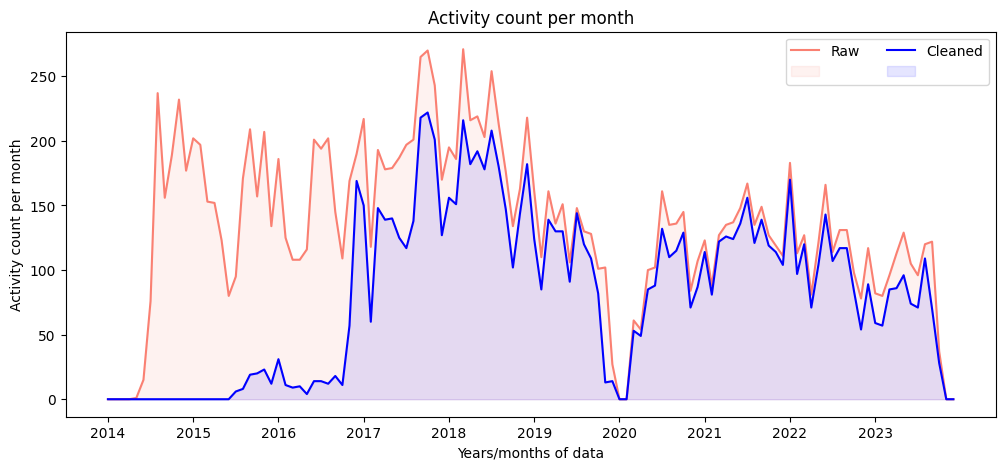

In [23]:
def fill_year_months_on_count_series(series, all_years):
    for year in all_years:
        for month in range(1, 13):
            if not (year, month) in series.index:
                series.loc[(year, month)] = 0
    return series.sort_index().reset_index()

def plot_activities_over_time(frame_to_plot, ax, colour, all_years): 
    activity_per_year_frame = pd.to_datetime(frame_to_plot['start_time'], format='ISO8601')
    activity_per_year_frame = activity_per_year_frame.groupby([activity_per_year_frame.dt.year,activity_per_year_frame.dt.month]).count()
    activity_per_year_frame.index.names = ['year', 'month']
    activity_per_year_frame = fill_year_months_on_count_series(activity_per_year_frame, all_years)
    activity_per_year_frame.rename(columns={'start_time': 'count'}, inplace=True)
    ax.plot(activity_per_year_frame.index, activity_per_year_frame['count'], color=colour)
    ax.fill_between(activity_per_year_frame.index, activity_per_year_frame['count'], color=colour, alpha=0.1)

def build_raw_activity_frame():
    raw_activity_frame = pd.DataFrame(raw_activity_rows)
    raw_activity_frame['year'] = raw_activity_frame['start_time'].str[:4].astype(int)
    all_years = raw_activity_frame['year'].unique()
    return raw_activity_frame, all_years 

def plot_raw_versus_cleaned_activities_overtime(raw_activity_frame, activity_frame, all_years):
    _, ax = plt.subplots(1, 1, figsize=(12, 5))
    plot_activities_over_time(raw_activity_frame, ax, 'salmon', all_years)
    plot_activities_over_time(activity_frame, ax, 'blue', all_years)
    ax.set_title('Activity count per month')
    ax.set_ylabel('Activity count per month')
    ax.set_xlabel('Years/months of data')
    ax.set_xticks(np.arange(0, len(all_years)*12, 12))
    ax.set_xticklabels(all_years)
    plt.legend(['Raw', None, 'Cleaned', None], ncol=2)
    plt.show()

raw_activity_frame, all_years = build_raw_activity_frame()
plot_raw_versus_cleaned_activities_overtime(raw_activity_frame, activity_frame, all_years)

### Prepare exercises

#### Load exercises dataset

In [24]:
exercise_dataset_frame = pd.read_csv('exercise_dataset.csv')
exercise_dataset_frame

,"Activity, Exercise or Sport (1 hour)",130 lb,155 lb,180 lb,205 lb,Calories per kg
0,"Cycling, mountain bike, bmx",502,598,695,791,1.750730
1,"Cycling, <10 mph, leisure bicycling",236,281,327,372,0.823236
2,"Cycling, >20 mph, racing",944,1126,1308,1489,3.294974
3,"Cycling, 10-11.9 mph, light",354,422,490,558,1.234853
4,"Cycling, 12-13.9 mph, moderate",472,563,654,745,1.647825
...,...,...,...,...,...,...
243,General cleaning,207,246,286,326,0.721008
244,"Cleaning, dusting",148,176,204,233,0.515199
245,Taking out trash,177,211,245,279,0.617427
246,"Walking, pushing a wheelchair",236,281,327,372,0.823236


#### Extract merge-able features

We can safely reduce the exercise categories to those existing in the already prepared location history activities, which will be the active calorie burning subset, but first we manually segregate the existing activity types into active and inactive, to focus exercise name parsing to the exercises of interest:

**ACTION REQUIRED: Match the desired `active_activity_types` to those active activities found above in `plot_activity_types`**

In [25]:
activity_types = set(activity_frame['activity_type'].unique())
active_activity_types = {'CYCLING', 'RUNNING', 'WALKING'}
print('Active activity types = ' + str(active_activity_types))
print('Inactive activity types = ' + str(activity_types - active_activity_types))

Active activity types = {'CYCLING', 'RUNNING', 'WALKING'}
Inactive activity types = {'MOTORCYCLING', 'FLYING', 'IN_TRAM', 'IN_BUS', 'IN_TRAIN', 'IN_PASSENGER_VEHICLE', 'IN_FERRY', 'IN_SUBWAY'}


We can then parse from active activity types from exercise names into an activity types column. And we can then drop those without an activity types as not relevant:

In [26]:
def extract_activity_type_column(exercise_dataset_frame, categorical_activity_type):
    active_activity_types_capture_regex = '(' + '|'.join(active_activity_types) + ')'
    exercise_dataset_frame['activity_type'] = exercise_dataset_frame['Activity, Exercise or Sport (1 hour)'] \
        .str.upper().str.extract(active_activity_types_capture_regex)
    exercise_dataset_frame = exercise_dataset_frame[exercise_dataset_frame['activity_type'].notnull()]
    exercise_dataset_frame['activity_type'] = exercise_dataset_frame['activity_type'].astype(categorical_activity_type)
    return exercise_dataset_frame

exercise_dataset_frame = extract_activity_type_column(exercise_dataset_frame, categorical_activity_type)
exercise_dataset_frame

C:\Users\kevin\AppData\Local\Temp\ipykernel_31108\938241096.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exercise_dataset_frame['activity_type'] = exercise_dataset_frame['activity_type'].astype(categorical_activity_type)


,"Activity, Exercise or Sport (1 hour)",130 lb,155 lb,180 lb,205 lb,Calories per kg,activity_type
0,"Cycling, mountain bike, bmx",502,598,695,791,1.750730,CYCLING
1,"Cycling, <10 mph, leisure bicycling",236,281,327,372,0.823236,CYCLING
2,"Cycling, >20 mph, racing",944,1126,1308,1489,3.294974,CYCLING
3,"Cycling, 10-11.9 mph, light",354,422,490,558,1.234853,CYCLING
4,"Cycling, 12-13.9 mph, moderate",472,563,654,745,1.647825,CYCLING
5,"Cycling, 14-15.9 mph, vigorous",590,704,817,931,2.059443,CYCLING
6,"Cycling, 16-19 mph, very fast, racing",708,844,981,1117,2.471061,CYCLING
7,Unicycling,295,352,409,465,1.029722,CYCLING
8,"Stationary cycling, very light",177,211,245,279,0.617427,CYCLING
9,"Stationary cycling, light",325,387,449,512,1.132626,CYCLING


To merge this to the existing activities frame, we need a secondary merge column to distinguish the correct row, which relates to speed/intensity of the exercise.

Relevant exercise speeds/intensity can be visually seen for the known exercise types as those with "mph", which can be parsed into a lower bound speed.

Before adding the speed/intensity column, the previous visual inspection shows that most rows are still not relevant, and the frame rows can be further dropped to just those with relevant speeds/intensities to the existing activities frame for ease of analysis:

**ACTION REQUIRED: Match the below `reduce_exercise_rows_to_existing_activity_types` filtering to your desired `active_activity_types`, and ensure the `lowest_bound_regex` is appropriate for your exercise types**

In [44]:
def reduce_exercise_rows_to_existing_activity_types(exercise_dataset_frame):
    exercise_dataset_frame = exercise_dataset_frame[exercise_dataset_frame['Activity, Exercise or Sport (1 hour)']
        .str.lower().str.contains('mph')]
    return exercise_dataset_frame

def extract_speed_column(exercise_dataset_frame):
    # set first numeric found in activity name as speed lower bound (e.g. "Cycling, 10-11.9 mph, light" = 10)
    low_bound_capture_regex = r'(\d+[.]?\d*)'
    exercise_dataset_frame['activity_type_speed_lower_bound'] = exercise_dataset_frame['Activity, Exercise or Sport (1 hour)'] \
        .str.extract(low_bound_capture_regex).astype(float)
    # overwrite the lower bound to 0 for those containing "<" or "under", or where there is no numeric value at all
    lowest_bound_regex = r'^.*<\d.*|.*under \d.*|\D+$'
    exercise_dataset_frame.loc[
        exercise_dataset_frame['Activity, Exercise or Sport (1 hour)'].str.match(lowest_bound_regex), 
        'activity_type_speed_lower_bound'] = 0

exercise_dataset_frame = reduce_exercise_rows_to_existing_activity_types(exercise_dataset_frame)
extract_speed_column(exercise_dataset_frame)
exercise_dataset_frame

,"Activity, Exercise or Sport (1 hour)",130 lb,155 lb,180 lb,205 lb,Calories per kg,activity_type,activity_type_speed_lower_bound
1,"Cycling, <10 mph, leisure bicycling",236,281,327,372,0.823236,CYCLING,0.0
2,"Cycling, >20 mph, racing",944,1126,1308,1489,3.294974,CYCLING,20.0
3,"Cycling, 10-11.9 mph, light",354,422,490,558,1.234853,CYCLING,10.0
4,"Cycling, 12-13.9 mph, moderate",472,563,654,745,1.647825,CYCLING,12.0
5,"Cycling, 14-15.9 mph, vigorous",590,704,817,931,2.059443,CYCLING,14.0
6,"Cycling, 16-19 mph, very fast, racing",708,844,981,1117,2.471061,CYCLING,16.0
37,"Running, 5 mph (12 minute mile)",472,563,654,745,1.647825,RUNNING,5.0
38,"Running, 5.2 mph (11.5 minute mile)",531,633,735,838,1.852957,RUNNING,5.2
39,"Running, 6 mph (10 min mile)",590,704,817,931,2.059443,RUNNING,6.0
40,"Running, 6.7 mph (9 min mile)",649,774,899,1024,2.265252,RUNNING,6.7


Plot for visual verification:

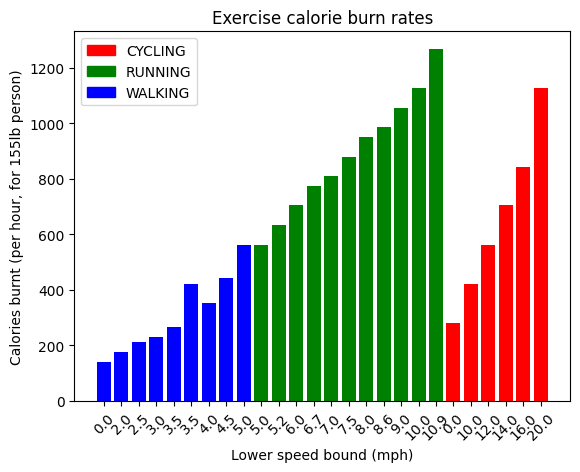

In [28]:
def plot_exercises_for_155_pounds():
    exercise_colour_mappings = {'CYCLING': 'red', 'RUNNING': 'green', 'WALKING': 'blue'}
    sorted_exercise_dataset_frame = exercise_dataset_frame.sort_values(by=['activity_type', 'activity_type_speed_lower_bound'])
    plt.bar(sorted_exercise_dataset_frame['Activity, Exercise or Sport (1 hour)'], 
        sorted_exercise_dataset_frame['155 lb'], 
        color=sorted_exercise_dataset_frame['activity_type'].map(exercise_colour_mappings))
    plt.xticks(ticks=sorted_exercise_dataset_frame.reset_index().index, 
        labels=sorted_exercise_dataset_frame['activity_type_speed_lower_bound'], rotation=45)
    plt.xlabel('Lower speed bound (mph)')
    plt.ylabel('Calories burnt (per hour, for 155lb person)')
    plt.title('Exercise calorie burn rates')
    legend_handles = [plt.Rectangle((0,0),1,1, color=exercise_colour_mappings[label]) 
        for label in exercise_colour_mappings.keys()]
    plt.legend(legend_handles, exercise_colour_mappings.keys())
    plt.show()

plot_exercises_for_155_pounds()

This reveals a duplicate in 3.5 mph walking needing removal. The irrelevant row is for "uphill" walking.

C:\Users\kevin\AppData\Local\Temp\ipykernel_31108\2006442277.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exercise_dataset_frame.drop(


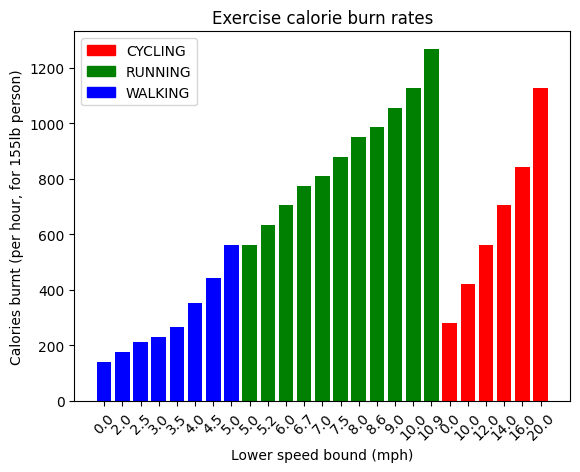

In [29]:
exercise_dataset_frame.drop(
    exercise_dataset_frame[exercise_dataset_frame['Activity, Exercise or Sport (1 hour)'].str.contains('uphill')].index, 
    inplace=True)
plot_exercises_for_155_pounds()

### Merge locations and exercises

#### Merge

We have activity type on both frames but need 'activity_type_speed_lower_bound' on the activity frame. We have the base features of 'distance' and 'start_time'/'end_time' to generate this, but it requires several intermediate steps, which will be inserted as columns in the code below for verifiability:

In [30]:
def create_speed_mph_feature():
    METRES_PER_MILE = 1609.34
    ONE_HOUR = pd.Timedelta(hours=1)

    activity_frame['duration'] = (activity_frame['end_time'] - activity_frame['start_time']) \
        if np.in1d(['start_time', 'end_time'], activity_frame.keys()).all() else None
    activity_frame['duration_hours'] = activity_frame['duration'] / ONE_HOUR \
        if np.in1d(['duration'], activity_frame.keys()).all() else None
    activity_frame['distance_miles'] = activity_frame['distance'] / METRES_PER_MILE \
        if np.in1d(['distance'], activity_frame.keys()).all() else None
    activity_frame['speed_mph'] = activity_frame['distance_miles'] / activity_frame['duration_hours'] \
        if np.in1d(['distance_miles', 'duration_hours'], activity_frame.keys()).all() else None

def get_speed_lower_bound(activity_type, speed_mph):
    return exercise_dataset_frame[(exercise_dataset_frame['activity_type'] == activity_type) & (exercise_dataset_frame['activity_type_speed_lower_bound'] <= speed_mph)] \
        ['activity_type_speed_lower_bound'].max()

def create_speed_lower_bound_feature():
    # There are faster ways then using apply to iterate, but this simple approach is sufficient for this data set size
    activity_frame['activity_type_speed_lower_bound'] = activity_frame[['activity_type', 'speed_mph']] \
        .apply(lambda columns: get_speed_lower_bound(*columns), axis=1) \
        if np.in1d(['activity_type', 'speed_mph'], activity_frame.keys()).all() else None

create_speed_mph_feature()
create_speed_lower_bound_feature()
activity_frame[activity_frame['activity_type'] == 'WALKING'].head()

,start_location_longitude,start_location_latitude,end_location_longitude,end_location_latitude,start_time,end_time,distance,activity_type,end_place_semantic_type,start_place_semantic_type,start_place_duration,end_place_duration,duration,duration_hours,distance_miles,speed_mph,activity_type_speed_lower_bound
3273,-0.200509,51.547151,-0.192550,51.548447,2016-12-01 09:03:10+00:00,2016-12-01 09:12:10.672000+00:00,544.0,WALKING,OTHER,OTHER,0 days 05:00:09.138189462,0 days 00:17:36.524000,0 days 00:09:00.672000,0.150187,0.338027,2.250711,2.0
3275,-0.107025,51.519890,-0.103086,51.516266,2016-12-01 09:43:42.096000+00:00,2016-12-01 09:50:29.322000+00:00,490.0,WALKING,OTHER,OTHER,0 days 05:00:09.138189462,0 days 02:50:55.883000,0 days 00:06:47.226000,0.113118,0.304473,2.691629,2.5
3276,-0.103114,51.516493,-0.103114,51.516493,2016-12-01 12:41:25.205000+00:00,2016-12-01 12:55:54.372000+00:00,633.0,WALKING,OTHER,OTHER,0 days 02:50:55.883000,0 days 05:32:04.628000,0 days 00:14:29.167000,0.241435,0.393329,1.629128,0.0
3277,-0.103114,51.516493,-0.105302,51.520740,2016-12-01 18:27:59+00:00,2016-12-01 18:34:54.192000+00:00,500.0,WALKING,OTHER,OTHER,0 days 05:32:04.628000,0 days 05:19:19.108574307,0 days 00:06:55.192000,0.115331,0.310686,2.693864,2.5
3280,-0.200509,51.547151,-0.204608,51.547038,2016-12-02 09:29:57.875000+00:00,2016-12-02 09:35:29+00:00,217.0,WALKING,OTHER,TYPE_HOME,0 days 14:03:12.875000,0 days 05:19:19.108574307,0 days 00:05:31.125000,0.091979,0.134838,1.465961,0.0


An illustrative weight can be chosen defining calories burnt, and here 155 lb is chosen as the closest match to the subject's typical weight:

Note: also we can drop the merge specific columns of 'activity_type_speed_lower_bound' and 'distance_miles'

**ACTION: merge based on an appropriate weight column for yourself**

In [31]:
def merge_exercises_into_activities(activity_frame):
    merge_on_columns = ['activity_type', 'activity_type_speed_lower_bound'] 
    # drop previous merged columns for safety against reruns
    activity_frame = activity_frame[activity_frame.columns.drop(list(activity_frame.filter(regex='155')))]
    activity_frame = activity_frame.merge(exercise_dataset_frame[merge_on_columns + ['155 lb']], on = merge_on_columns, how = 'left')
    activity_frame.rename(columns={'155 lb': 'calories_burned_hourly'}, inplace=True)
    activity_frame.drop(columns=['activity_type_speed_lower_bound', 'distance_miles'], inplace=True)
    return activity_frame

activity_frame = merge_exercises_into_activities(activity_frame)
activity_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9835 entries, 0 to 9834
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   start_location_longitude   9835 non-null   float64            
 1   start_location_latitude    9835 non-null   float64            
 2   end_location_longitude     9835 non-null   float64            
 3   end_location_latitude      9835 non-null   float64            
 4   start_time                 9835 non-null   datetime64[ns, UTC]
 5   end_time                   9835 non-null   datetime64[ns, UTC]
 6   distance                   9835 non-null   float64            
 7   activity_type              9835 non-null   category           
 8   end_place_semantic_type    9835 non-null   category           
 9   start_place_semantic_type  9835 non-null   category           
 10  start_place_duration       9835 non-null   timedelta64[ns]    
 11  end_

#### Cleanse merged nulls

For the activity types not merged a calorie burn of zero is sufficient:

In [32]:
activity_frame['calories_burned_hourly'].fillna(0, inplace=True)
activity_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9835 entries, 0 to 9834
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   start_location_longitude   9835 non-null   float64            
 1   start_location_latitude    9835 non-null   float64            
 2   end_location_longitude     9835 non-null   float64            
 3   end_location_latitude      9835 non-null   float64            
 4   start_time                 9835 non-null   datetime64[ns, UTC]
 5   end_time                   9835 non-null   datetime64[ns, UTC]
 6   distance                   9835 non-null   float64            
 7   activity_type              9835 non-null   category           
 8   end_place_semantic_type    9835 non-null   category           
 9   start_place_semantic_type  9835 non-null   category           
 10  start_place_duration       9835 non-null   timedelta64[ns]    
 11  end_

### Compute features

#### Cluster transform locations

To avoid the limitation of installing libraries outside of of the anaconda base libraries, the following enables an approximation of a map plot:

In [33]:
from matplotlib import image 
world_map_image = image.imread('images/BlankMap-World-Equirectangular.png') 

def apply_world_image_backdrop(ax):
    world_map_image_boundaries = [-184.869, 213.651, -100.1, 97.9]
    ax.imshow(world_map_image, extent=world_map_image_boundaries) 

First we can visualise locations prior to clustering:

**ACTION: define `map_regions` of interest to yourself**

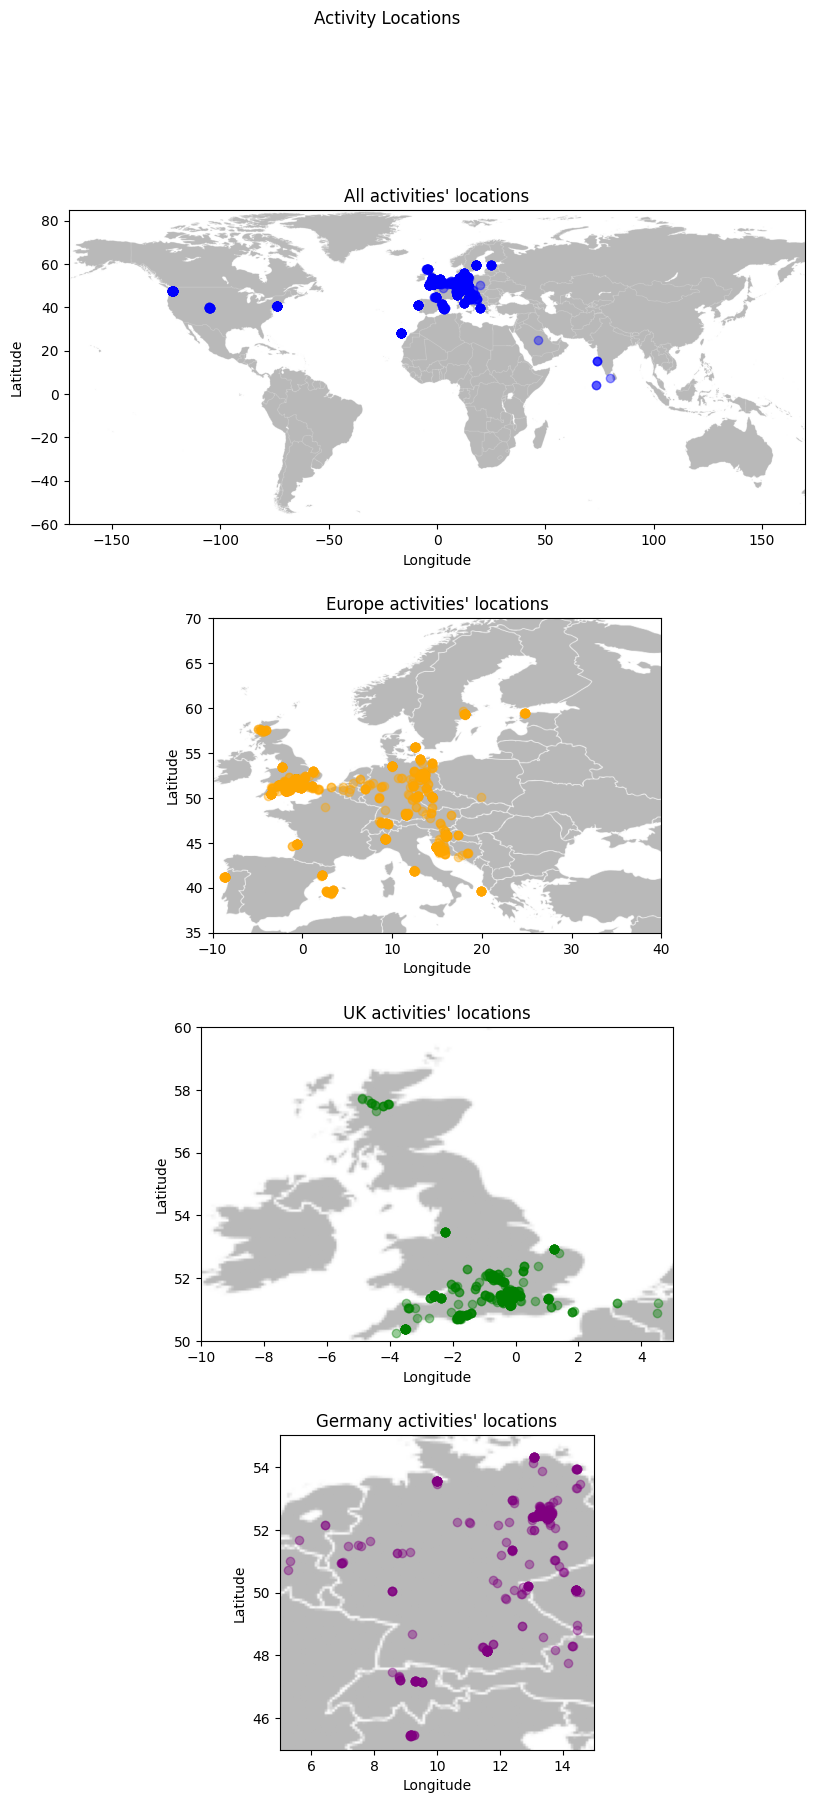

In [34]:
def plot_map(ax, activity_frame, x_limits, y_limits, title, colours):
    ax.scatter(
        x=activity_frame['start_location_longitude'], 
        y=activity_frame['start_location_latitude'], 
        alpha=0.4,
        c=colours)
    ax.set_title(title)
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    apply_world_image_backdrop(ax)

map_regions = {
    'All activities\' locations': ([-170, 170], [-60, 85], 'blue'),
    'Europe activities\' locations': ((-10, 40), (35, 70), 'orange'),
    'UK activities\' locations': ((-10, 5), (50, 60), 'green'),
    'Germany activities\' locations': ((5, 15), (45, 55), 'purple')
}

def plot_all_regions_maps_of_activities():
    fig, axes = plt.subplots(len(map_regions), 1, figsize=(40, 20))
    for index, (title, (x_limits, y_limits, colour)) in enumerate(map_regions.items()):
        plot_map(axes[index], activity_frame, x_limits, y_limits, title, colour)
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle('Activity Locations')
    plt.show()

plot_all_regions_maps_of_activities()

As planned we will first do KMeans clustering at local/city granularity. To achieve city resolution clustering the cluster quantity was incremented until the next increment would split a city: 

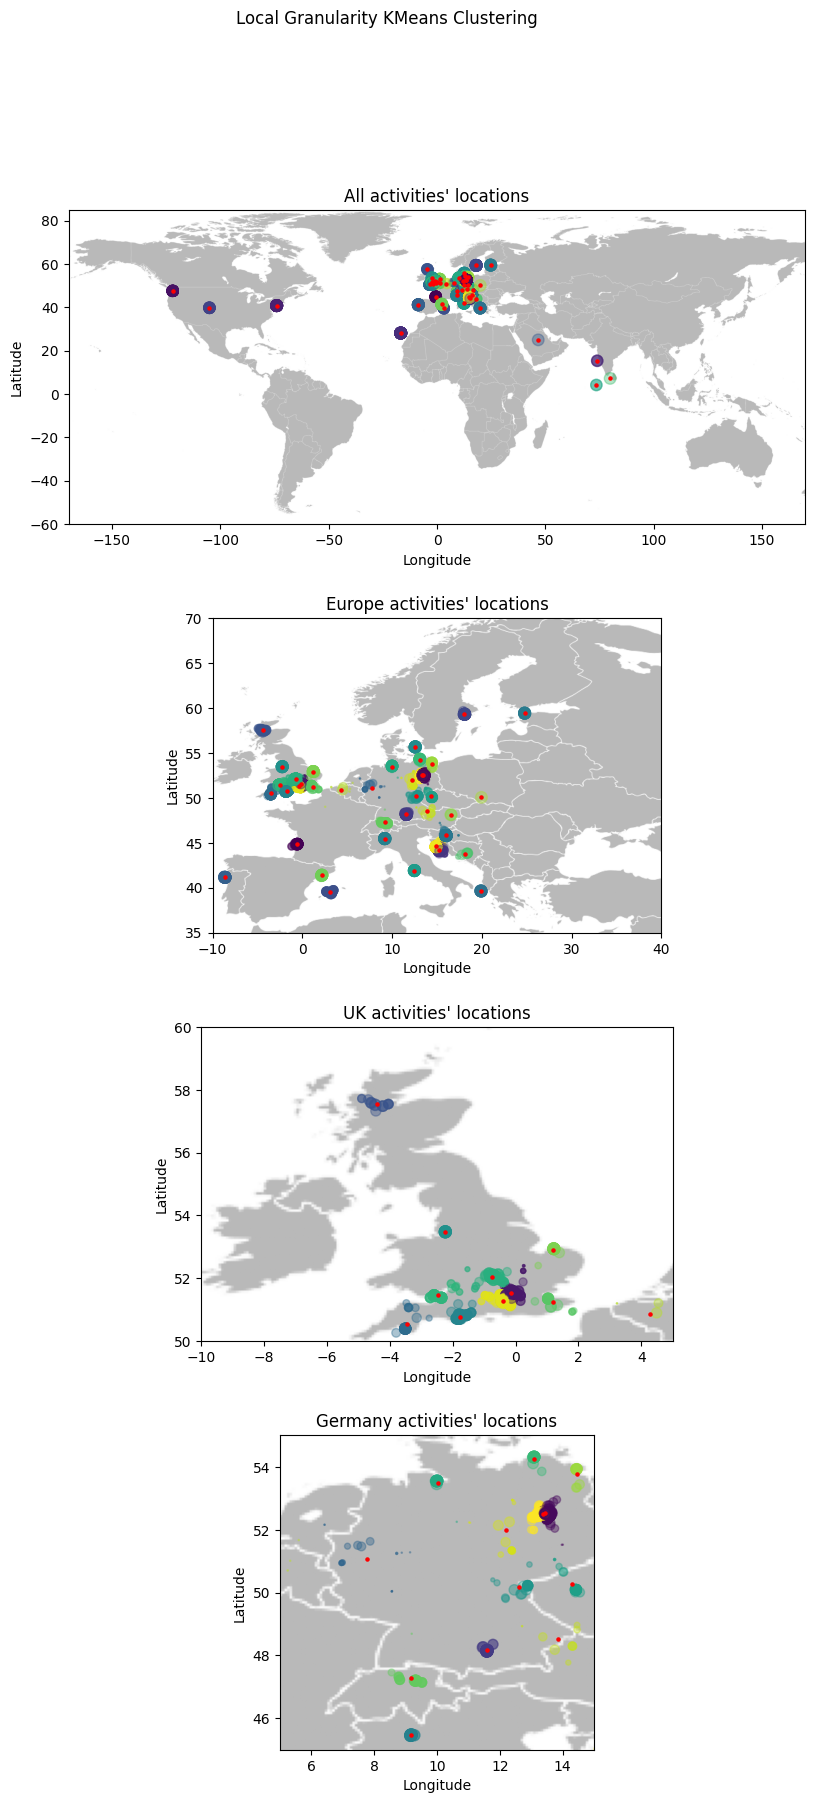

In [35]:
def kmeans_cluster_locations(activity_frame, n_clusters):
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    cluster_labels = kmeans_model.fit_predict(activity_frame[['start_location_longitude', 'start_location_latitude']])
    cluster_distances = kmeans_model.transform(activity_frame[['start_location_longitude', 'start_location_latitude']])
    return cluster_labels, cluster_distances, kmeans_model.cluster_centers_

def get_cluster_distances_for_row_cluster_labels(activity_cluster_series, cluster_distances):
    # create a frame with distances to all clusters for every activity row
    cluster_distances_frame = pd.DataFrame(data=cluster_distances, index=activity_frame.index) 
    cluster_distances_frame['cluster_label'] = activity_cluster_series
    # lookup correct cluster distance for activity row's cluster label
    idx, cols = pd.factorize(cluster_distances_frame['cluster_label'])
    return cluster_distances_frame.reindex(cols, axis=1).to_numpy()[np.arange(len(cluster_distances_frame)), idx]

def map_cluster_distance_to_plot_size(cluster_distance_series, minimum_distance, maximum_distance):
    LARGEST_PLOT_SIZE = 70
    return np.maximum(maximum_distance-cluster_distance_series, minimum_distance) * (LARGEST_PLOT_SIZE/maximum_distance)

def plot_map_with_clusters(ax, activity_longitudes, activity_latitudes, activity_clusters, activity_distance_size, clusters_frame, x_limits, y_limits, title):
    ax.scatter(x=activity_longitudes, y=activity_latitudes, alpha=0.4,c=activity_clusters, s=activity_distance_size)
    ax.scatter(clusters_frame['longitude'], clusters_frame['latitude'], c='red', s=5)
    ax.set_title(title)
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    apply_world_image_backdrop(ax)

def plot_all_regions_maps_of_local_clusters():
    fig, axes = plt.subplots(len(map_regions), 1, figsize=(40, 20))
    for index, (title, (x_limits, y_limits, colour)) in enumerate(map_regions.items()):
        plot_map_with_clusters(axes[index], 
            activity_frame['start_location_longitude'], 
            activity_frame['start_location_latitude'], 
            activity_frame['location_local_cluster'],
            activity_frame['location_local_cluster_distance_plot_size'],
            local_cluster_locations_frame,
            x_limits, y_limits, title)
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle('Local Granularity KMeans Clustering')
    plt.show()

def create_local_location_activity_features(local_cluster_labels, local_cluster_distances):
    activity_frame['location_local_cluster'] = local_cluster_labels.astype(int)
    activity_frame['location_local_cluster_distance'] = get_cluster_distances_for_row_cluster_labels(
        activity_frame['location_local_cluster'], 
        local_cluster_distances)
    activity_frame['location_local_cluster_distance_plot_size'] = map_cluster_distance_to_plot_size(
        activity_frame['location_local_cluster_distance'], 
        minimum_distance=0.01, maximum_distance=1)

# city/local resolution (incrementing n_clusters to 48 splits Berlin)
local_cluster_labels, local_cluster_distances, local_cluster_locations = kmeans_cluster_locations(activity_frame, n_clusters=47)
create_local_location_activity_features(local_cluster_labels, local_cluster_distances)
local_cluster_locations_frame = pd.DataFrame(data=local_cluster_locations, columns=['longitude', 'latitude'])

plot_all_regions_maps_of_local_clusters()

Secondly we cluster locations at a country level of granularity. To achieve country resolution clustering the cluster quantity was incremented until the next increment would split a country:

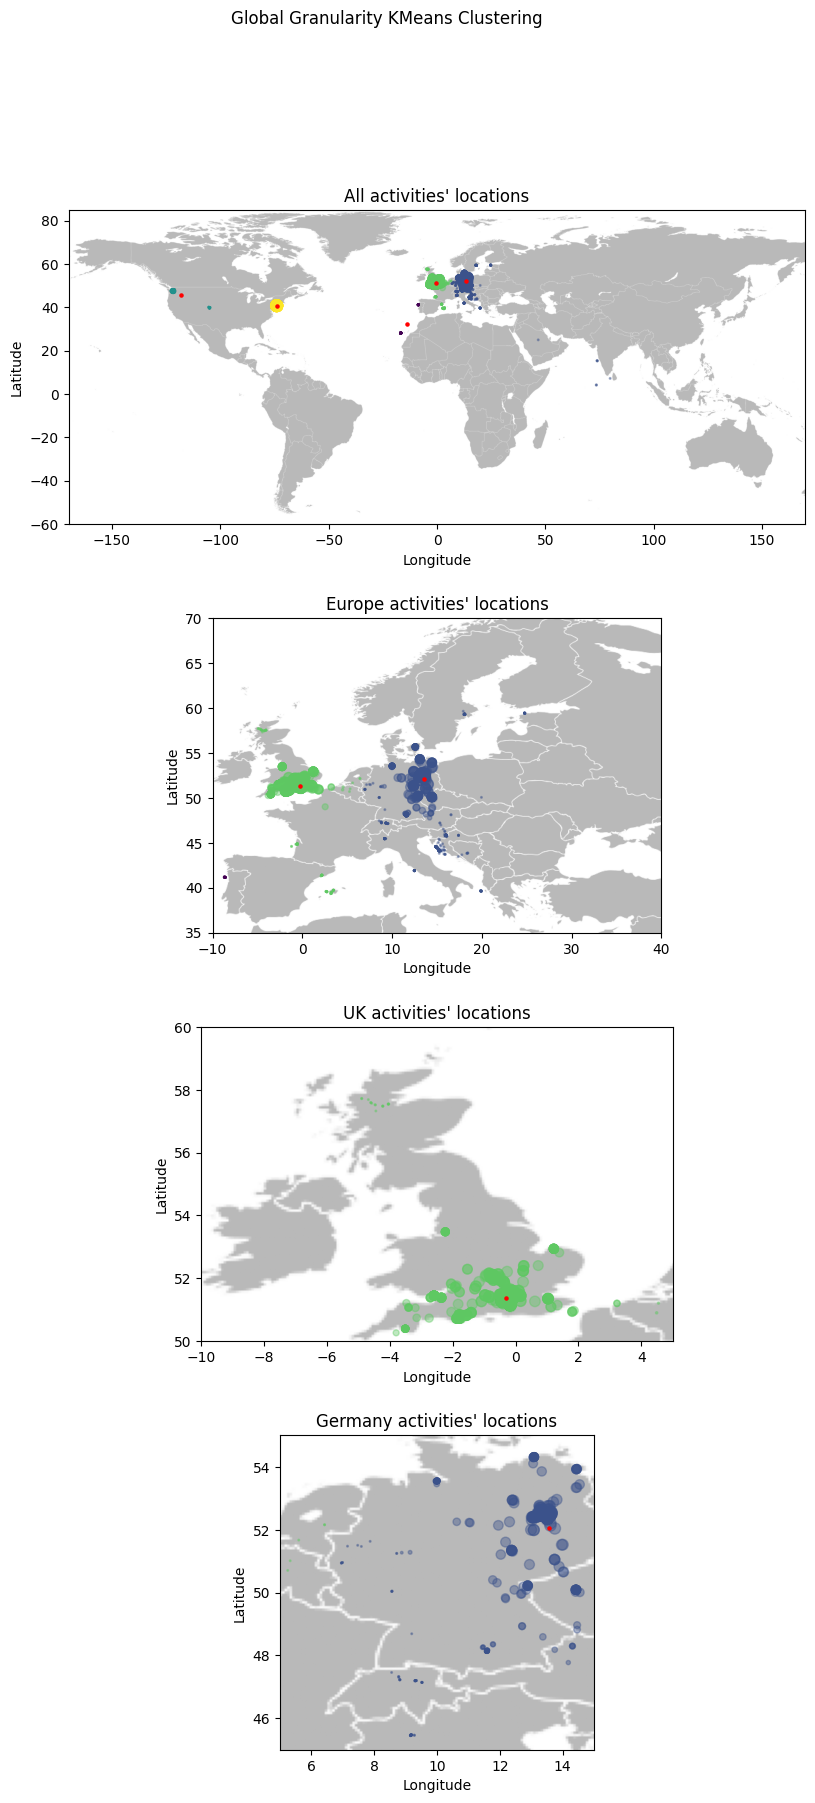

In [36]:
def plot_all_regions_maps_of_global_clusters():
    fig, axes = plt.subplots(len(map_regions), 1, figsize=(40, 20))
    for index, (title, (x_limits, y_limits, colour)) in enumerate(map_regions.items()):
        plot_map_with_clusters(axes[index], 
            activity_frame['start_location_longitude'], 
            activity_frame['start_location_latitude'], 
            activity_frame['location_global_cluster'],
            activity_frame['location_global_cluster_distance_plot_size'],
            global_cluster_locations_frame,
            x_limits, y_limits, title)
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle('Global Granularity KMeans Clustering')
    plt.show()

def create_global_location_activity_features(global_cluster_labels, global_cluster_distances):
    activity_frame['location_global_cluster'] = global_cluster_labels.astype(int)
    activity_frame['location_global_cluster_distance'] = get_cluster_distances_for_row_cluster_labels(
        activity_frame['location_global_cluster'], 
        global_cluster_distances)
    activity_frame['location_global_cluster_distance_plot_size'] = map_cluster_distance_to_plot_size(
        activity_frame['location_global_cluster_distance'], 
        minimum_distance=0.1, maximum_distance=5)

# country/global resolution (incrementing n_clusters to 6 splits US)
global_cluster_labels, global_cluster_distances, global_cluster_locations = kmeans_cluster_locations(activity_frame, n_clusters=5)
create_global_location_activity_features(global_cluster_labels, global_cluster_distances)
global_cluster_locations_frame = pd.DataFrame(data=global_cluster_locations, columns=['longitude', 'latitude'])
plot_all_regions_maps_of_global_clusters()

#### Group transform temporal features

The following features, all transformed from `start_time` into different resolutions as candidates for correlation:

In [37]:
PHASE_OF_DAY_LABELS = ['Night(00-06)', 'Morning(06-12)', 'Afternoon(12-18)', 'Evening(18-24)']
SEASON_LABELS = ['Winter', 'Spring', 'Summer', 'Autumn']

def create_time_of_day_features():
    activity_frame['start_hour'] = activity_frame['start_time'].dt.hour
    activity_frame['start_phase_of_day'] = pd.cut(activity_frame['start_hour'], bins=[0, 6, 12, 18, 24], labels=PHASE_OF_DAY_LABELS)
    activity_frame['start_day_of_week'] = activity_frame['start_time'].dt.day_name()
    activity_frame['start_month_of_year'] = activity_frame['start_time'].dt.month_name()
    activity_frame['start_season'] = pd.cut(activity_frame['start_time'].dt.month, bins=[0, 3, 6, 9, 12], labels=SEASON_LABELS)

create_time_of_day_features()
activity_frame.sample(n=10)[['start_time', 'start_hour', 'start_phase_of_day', 'start_day_of_week', 'start_month_of_year', 'start_season']]

,start_time,start_hour,start_phase_of_day,start_day_of_week,start_month_of_year,start_season
2164,2017-09-18 08:26:13+00:00,8,Morning(06-12),Monday,September,Summer
6940,2021-07-05 10:10:46.919000+00:00,10,Morning(06-12),Monday,July,Summer
6621,2021-12-01 16:16:12.929000+00:00,16,Afternoon(12-18),Wednesday,December,Autumn
5744,2020-07-16 16:26:07.479000+00:00,16,Afternoon(12-18),Thursday,July,Summer
5682,2020-12-26 16:05:41.520000+00:00,16,Afternoon(12-18),Saturday,December,Autumn
898,2017-02-24 09:52:25.855000+00:00,9,Morning(06-12),Friday,February,Winter
7984,2022-08-22 11:48:28.060000+00:00,11,Morning(06-12),Monday,August,Summer
7090,2021-06-03 21:30:23.353000+00:00,21,Evening(18-24),Thursday,June,Spring
5243,2019-05-30 17:28:39.616000+00:00,17,Afternoon(12-18),Thursday,May,Spring
1139,2017-07-20 11:39:51.949000+00:00,11,Morning(06-12),Thursday,July,Summer


#### Create semantic place features

A further feature of interest is the commute category:

In [38]:
def create_commute_type_feature():
    activity_frame['commute_type'] = 'NONE'
    activity_frame.loc[((activity_frame['start_place_semantic_type'] == 'TYPE_WORK') 
                   & (activity_frame['end_place_semantic_type'] == 'TYPE_HOME')), 'commute_type'] = 'WORK_TO_HOME'
    activity_frame.loc[((activity_frame['start_place_semantic_type'] == 'TYPE_HOME') 
                   & (activity_frame['end_place_semantic_type'] == 'TYPE_WORK')), 'commute_type'] = 'HOME_TO_WORK'

create_commute_type_feature()
activity_frame[activity_frame['commute_type'] == 'WORK_TO_HOME'].head()

,start_location_longitude,start_location_latitude,end_location_longitude,end_location_latitude,start_time,end_time,distance,activity_type,end_place_semantic_type,start_place_semantic_type,...,location_local_cluster_distance_plot_size,location_global_cluster,location_global_cluster_distance,location_global_cluster_distance_plot_size,start_hour,start_phase_of_day,start_day_of_week,start_month_of_year,start_season,commute_type
42,-0.157569,51.523178,-0.204209,51.546928,2015-11-18 18:11:12.169000+00:00,2015-11-18 19:10:00.040000+00:00,5016.0,IN_SUBWAY,TYPE_HOME,TYPE_WORK,...,69.064984,3,0.197806,67.230718,18,Afternoon(12-18),Wednesday,November,Autumn,WORK_TO_HOME
446,-0.105172,51.520168,-0.191812,51.548477,2016-09-23 17:04:12.067000+00:00,2016-09-23 17:27:24.824000+00:00,8188.0,IN_TRAIN,TYPE_HOME,TYPE_WORK,...,67.004859,3,0.234728,66.713811,17,Afternoon(12-18),Friday,September,Summer,WORK_TO_HOME
875,-0.103564,51.513935,-0.192550,51.548447,2017-02-16 19:52:34.601000+00:00,2017-02-16 20:06:07.842000+00:00,8934.0,IN_TRAIN,TYPE_HOME,TYPE_WORK,...,66.763109,3,0.232311,66.747650,19,Evening(18-24),Thursday,February,Winter,WORK_TO_HOME
1089,-0.103314,51.516417,-0.200510,51.547152,2017-07-10 17:22:16.718000+00:00,2017-07-10 18:11:24+00:00,10110.0,RUNNING,TYPE_HOME,TYPE_WORK,...,66.805801,3,0.233973,66.724378,17,Afternoon(12-18),Monday,July,Summer,WORK_TO_HOME
1342,-0.103564,51.513935,-0.192550,51.548447,2017-03-09 17:16:49.169000+00:00,2017-03-09 17:31:44.998000+00:00,8934.0,IN_TRAIN,TYPE_HOME,TYPE_WORK,...,66.763109,3,0.232311,66.747650,17,Afternoon(12-18),Thursday,March,Winter,WORK_TO_HOME


#### Transform computed features' formats

In [39]:
activity_frame[['start_hour', 'start_phase_of_day', 'start_day_of_week', 'start_month_of_year', 'start_season', 'commute_type']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9835 entries, 0 to 9834
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   start_hour           9835 non-null   int32   
 1   start_phase_of_day   9764 non-null   category
 2   start_day_of_week    9835 non-null   object  
 3   start_month_of_year  9835 non-null   object  
 4   start_season         9835 non-null   category
 5   commute_type         9835 non-null   object  
dtypes: category(2), int32(1), object(3)
memory usage: 288.7+ KB


The ordinal categorical features all need to be typed as such: 

In [40]:
DAY_OF_WEEK_LABELS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
MONTH_LABELS = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December'] 

def transform_time_categorical_types():
    phase_of_day_categorical_type = CategoricalDtype(categories=PHASE_OF_DAY_LABELS, ordered=True)
    activity_frame['start_phase_of_day'] = activity_frame['start_phase_of_day'].astype(phase_of_day_categorical_type)

    day_of_week_categorical_type = CategoricalDtype(categories=DAY_OF_WEEK_LABELS, ordered=True)
    activity_frame['start_day_of_week'] = activity_frame['start_day_of_week'].astype(day_of_week_categorical_type)

    month_of_year_categorical_type = CategoricalDtype(categories=MONTH_LABELS, ordered=True)
    activity_frame['start_month_of_year'] = activity_frame['start_month_of_year'].astype(month_of_year_categorical_type)

    season_categorical_type = CategoricalDtype(categories=SEASON_LABELS, ordered=True)
    activity_frame['start_season'] = activity_frame['start_season'].astype(season_categorical_type)

transform_time_categorical_types()
activity_frame[['start_hour', 'start_phase_of_day', 'start_day_of_week', 'start_month_of_year', 'start_season']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9835 entries, 0 to 9834
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   start_hour           9835 non-null   int32   
 1   start_phase_of_day   9764 non-null   category
 2   start_day_of_week    9835 non-null   category
 3   start_month_of_year  9835 non-null   category
 4   start_season         9835 non-null   category
dtypes: category(4), int32(1)
memory usage: 78.1 KB


Additionally the commute feature needs to be a nominal category:

In [41]:
def transform_commute_types():
    commute_categorical_type = CategoricalDtype(categories=activity_frame['commute_type'].unique())
    activity_frame['commute_type'] = activity_frame['commute_type'].astype(commute_categorical_type)

transform_commute_types()
activity_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9835 entries, 0 to 9834
Data columns (total 28 columns):
 #   Column                                      Non-Null Count  Dtype              
---  ------                                      --------------  -----              
 0   start_location_longitude                    9835 non-null   float64            
 1   start_location_latitude                     9835 non-null   float64            
 2   end_location_longitude                      9835 non-null   float64            
 3   end_location_latitude                       9835 non-null   float64            
 4   start_time                                  9835 non-null   datetime64[ns, UTC]
 5   end_time                                    9835 non-null   datetime64[ns, UTC]
 6   distance                                    9835 non-null   float64            
 7   activity_type                               9835 non-null   category           
 8   end_place_semantic_type               

### Analyse

#### Compute target calories feature

In [42]:
activity_frame['calories_burned'] = activity_frame['calories_burned_hourly'] * activity_frame['duration_hours']

#### Correlate quantitive features

In order to see the full colour map range we ensure that the 1 and -1 values exist, which is the target feature and it's inverse:

In [45]:
def build_quantitive_correlations(quantitive_features):
    quantitive_correlations = activity_frame[quantitive_features].corrwith(activity_frame["calories_burned"], numeric_only=True)
    quantitive_correlations.loc['calories_burned'] = 1
    quantitive_correlations.loc['inverse_calories_burned'] = -1
    return pd.DataFrame(quantitive_correlations, columns=['Correlation']).sort_values(by='Correlation', ascending=False)

location_quantitive_features = ['location_global_cluster_distance', 'location_local_cluster_distance']
styled_location_quantitive_correlations = build_quantitive_correlations(location_quantitive_features).style.background_gradient(cmap='coolwarm')
styled_location_quantitive_correlations

,Correlation
calories_burned,1.000000
location_global_cluster_distance,-0.013516
location_local_cluster_distance,-0.040767
inverse_calories_burned,-1.000000


In [46]:
temporal_quantitive_features = ['duration_hours', 'start_hour']
styled_temporal_quantitive_correlations = build_quantitive_correlations(temporal_quantitive_features).style.background_gradient(cmap='coolwarm')
styled_temporal_quantitive_correlations

,Correlation
calories_burned,1.000000
duration_hours,0.611989
start_hour,0.001319
inverse_calories_burned,-1.000000


#### Correlate qualitative features

As with quantitive, we add the target feature and it's inverse for full range:

In [47]:
import scipy.stats as stats
from sklearn import preprocessing

def qualitative_correlation(feature_name):
    regression_frame = activity_frame[~activity_frame['calories_burned'].isnull() & ~activity_frame[feature_name].isnull()][['calories_burned', feature_name]]
    label_encoder = preprocessing.LabelEncoder()
    regression_frame[feature_name]= label_encoder.fit_transform(regression_frame[feature_name])
    return stats.pointbiserialr(regression_frame[feature_name], regression_frame['calories_burned']).statistic

def build_qualitative_correlations(qualitative_features):
    qualitative_correlations = [qualitative_correlation(feature_name) for feature_name in qualitative_features]
    qualitative_correlations_frame = pd.DataFrame(qualitative_correlations, index=qualitative_features, columns=['Correlation'])
    qualitative_correlations_frame.loc['calories_burned'] = 1
    qualitative_correlations_frame.loc['inverse_calories_burned'] = -1
    return qualitative_correlations_frame.sort_values(by='Correlation', ascending=False)

location_qualitative_features = ['location_local_cluster', 'location_global_cluster']
styled_location_qualitative_correlations = build_qualitative_correlations(location_qualitative_features).style.background_gradient(cmap='coolwarm')
styled_location_qualitative_correlations

,Correlation
calories_burned,1.000000
location_local_cluster,0.006112
location_global_cluster,-0.060768
inverse_calories_burned,-1.000000


In [48]:
temporal_qualitative_features = ['start_phase_of_day', 'start_day_of_week', 'start_month_of_year', 'start_season']
styled_temporal_qualitative_correlations = build_qualitative_correlations(temporal_qualitative_features).style.background_gradient(cmap='coolwarm')
styled_temporal_qualitative_correlations

,Correlation
calories_burned,1.000000
start_day_of_week,0.028132
start_month_of_year,0.012104
start_phase_of_day,-0.000881
start_season,-0.002710
inverse_calories_burned,-1.000000


In [49]:
semantic_qualitative_features = ['start_place_semantic_type', 'end_place_semantic_type', 'commute_type']
styled_semantic_qualitative_correlations = build_qualitative_correlations(semantic_qualitative_features).style.background_gradient(cmap='coolwarm')
styled_semantic_qualitative_correlations

,Correlation
calories_burned,1.000000
start_place_semantic_type,0.137986
end_place_semantic_type,0.102648
commute_type,-0.014056
inverse_calories_burned,-1.000000


In order to get a better visualisation on these weak correlations a box plot can be used:

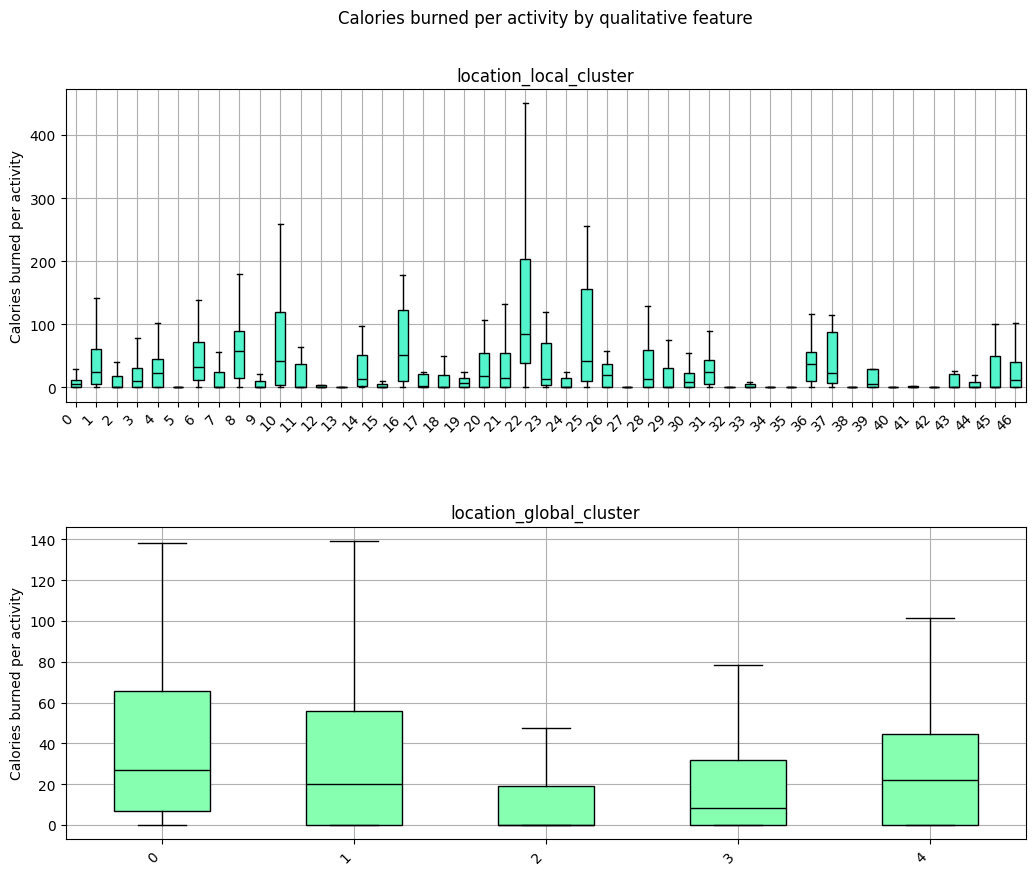

In [50]:
def set_boxplot_face_colours(boxplot_properties, colour):
    for _, (_, row) in boxplot_properties.items():
        for _, box in enumerate(row['boxes']):
            box.set_facecolor(colour)

def plot_qualitative_feature(feature_name, ax):
    boxplot_frame = activity_frame[['calories_burned', feature_name]]
    boxplot_properties = boxplot_frame.boxplot(by=feature_name, ax=ax, showfliers=False, patch_artist=True, color='black', return_type='both')
    set_boxplot_face_colours(boxplot_properties, plt.cm.rainbow(np.random.rand(1))[0])
    ax.set_title(feature_name)
    ax.set_ylabel('Calories burned per activity')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

def box_plot_qualitative_features(qualitative_features):
    fig, axes = plt.subplots(len(qualitative_features), 1, figsize=(12, 5*len(qualitative_features)))
    for index, feature_name in enumerate(qualitative_features):
        plot_qualitative_feature(feature_name, axes[index])
    fig.suptitle('Calories burned per activity by qualitative feature')
    fig.subplots_adjust(hspace=0.2*len(qualitative_features))
    plt.show()

box_plot_qualitative_features(location_qualitative_features)

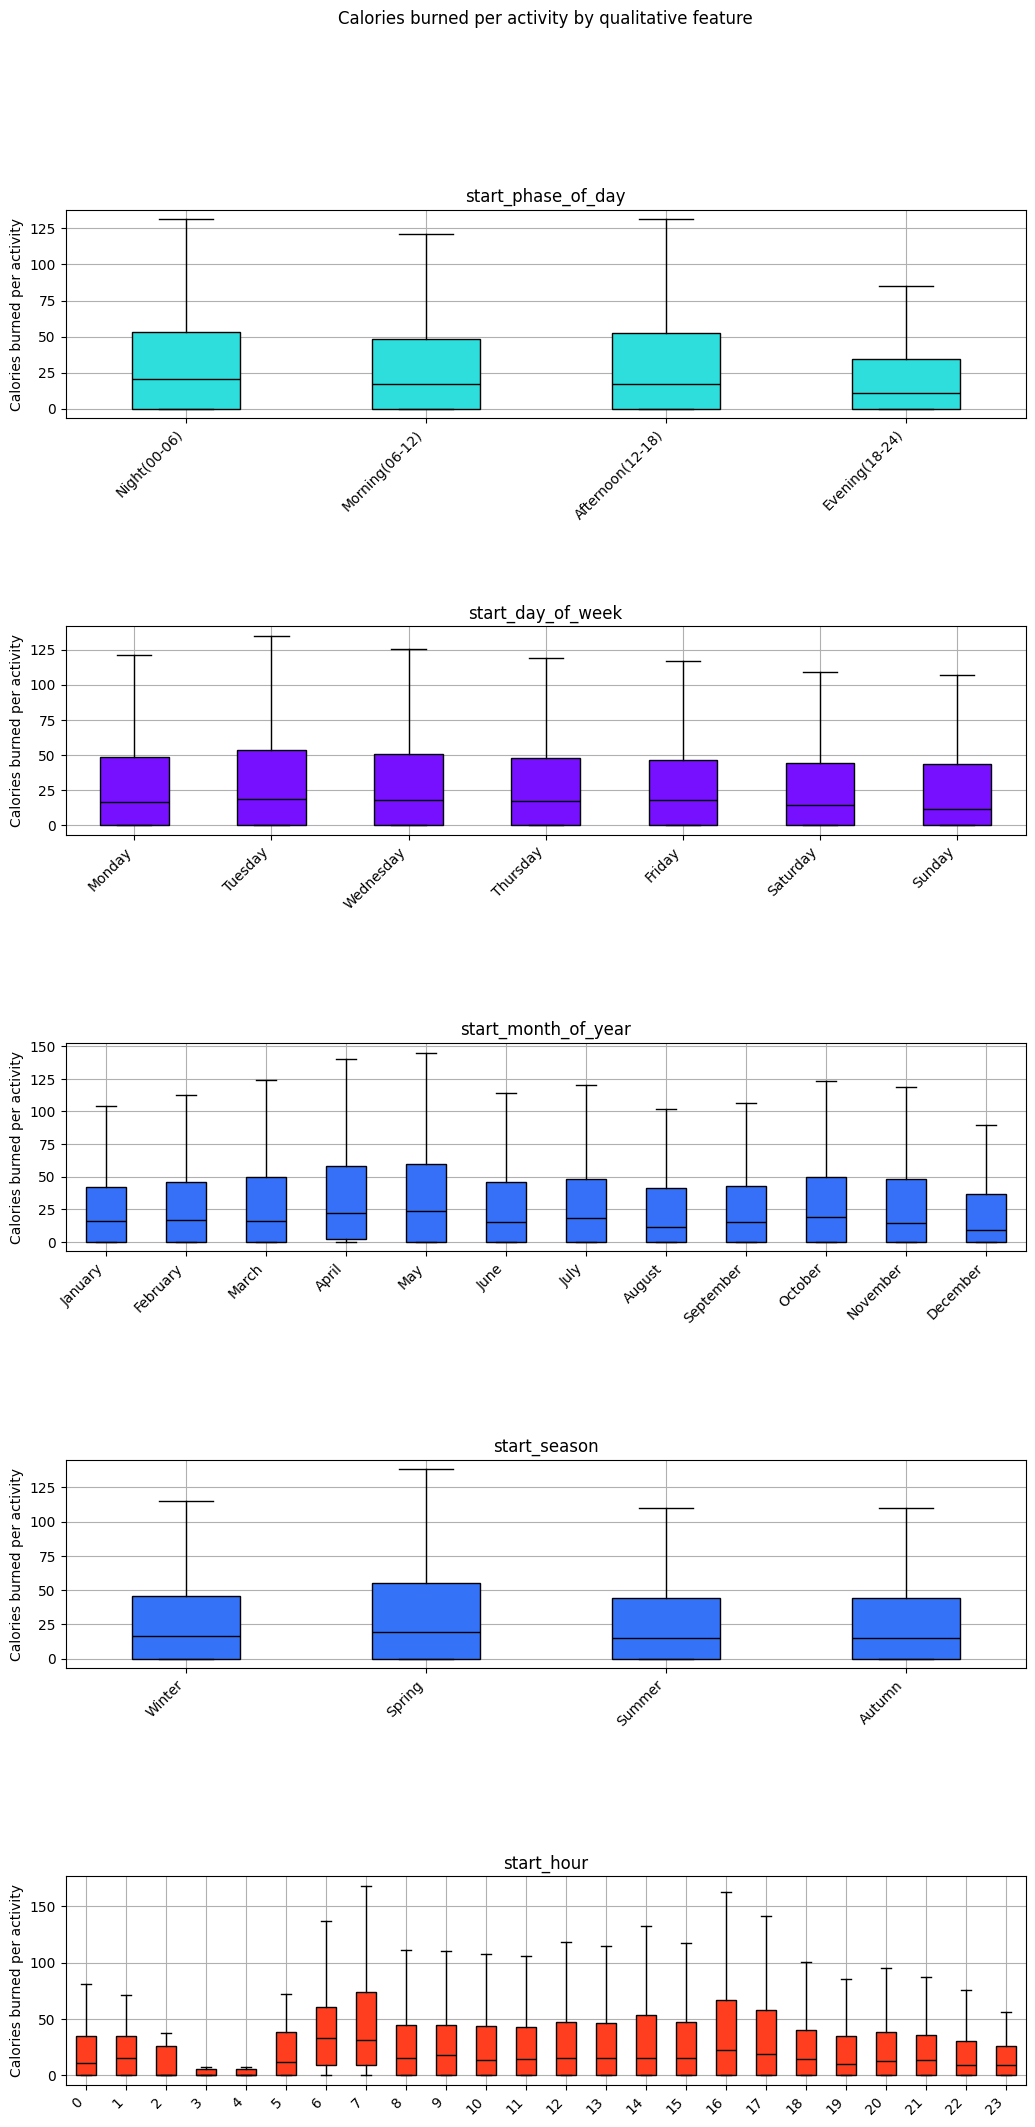

In [51]:
box_plot_qualitative_features(temporal_qualitative_features + ['start_hour'])

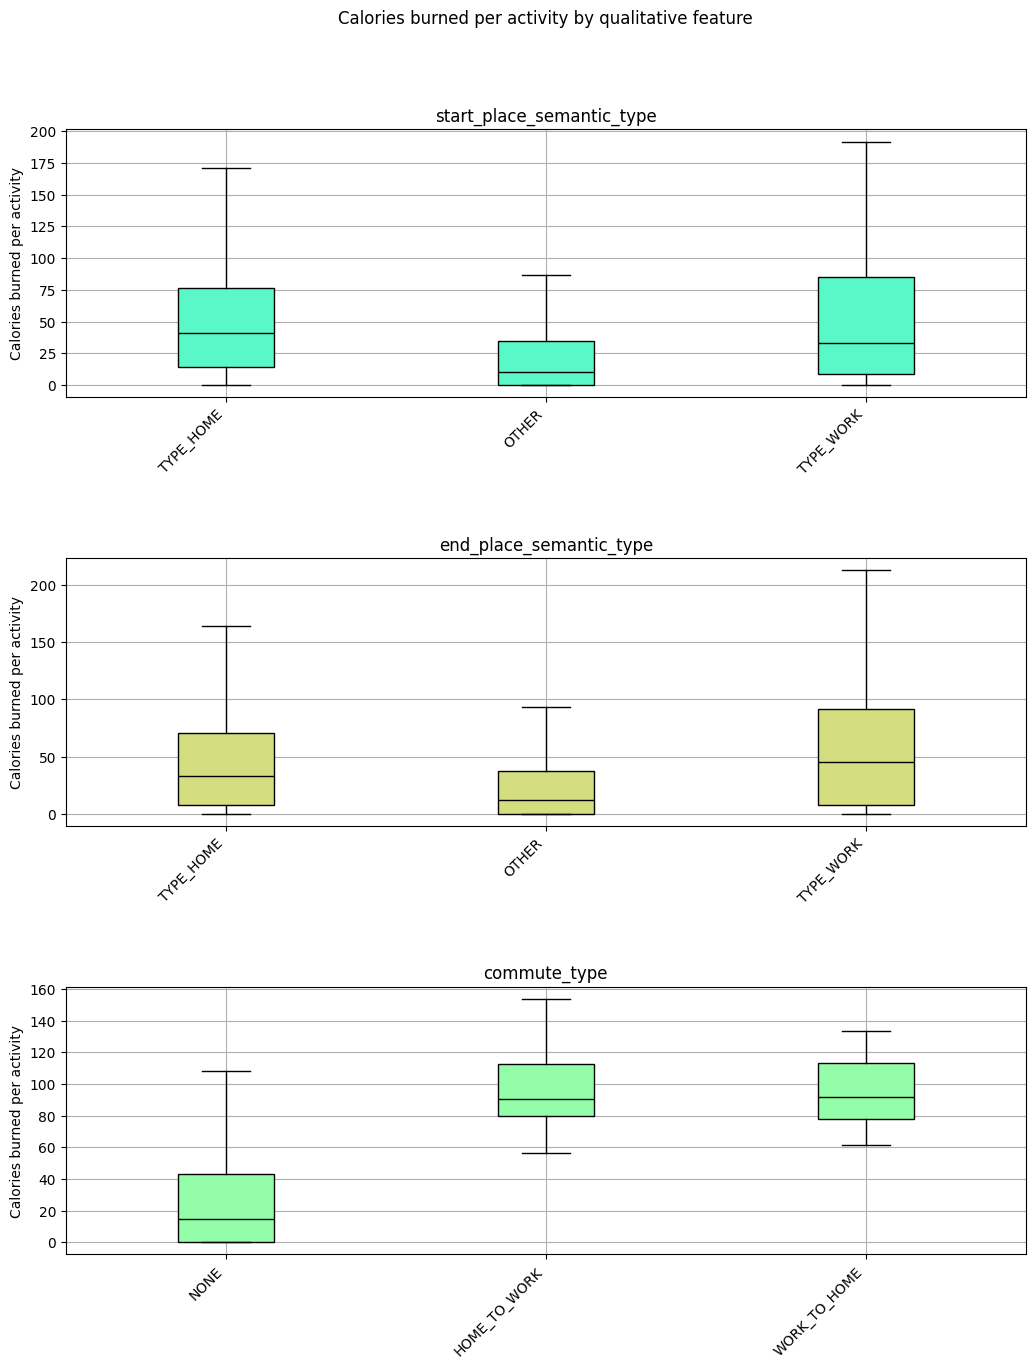

In [52]:
box_plot_qualitative_features(semantic_qualitative_features)

To expand on the interesting cluster correlations we map the clusters with calories burnt per cluster as the point size:

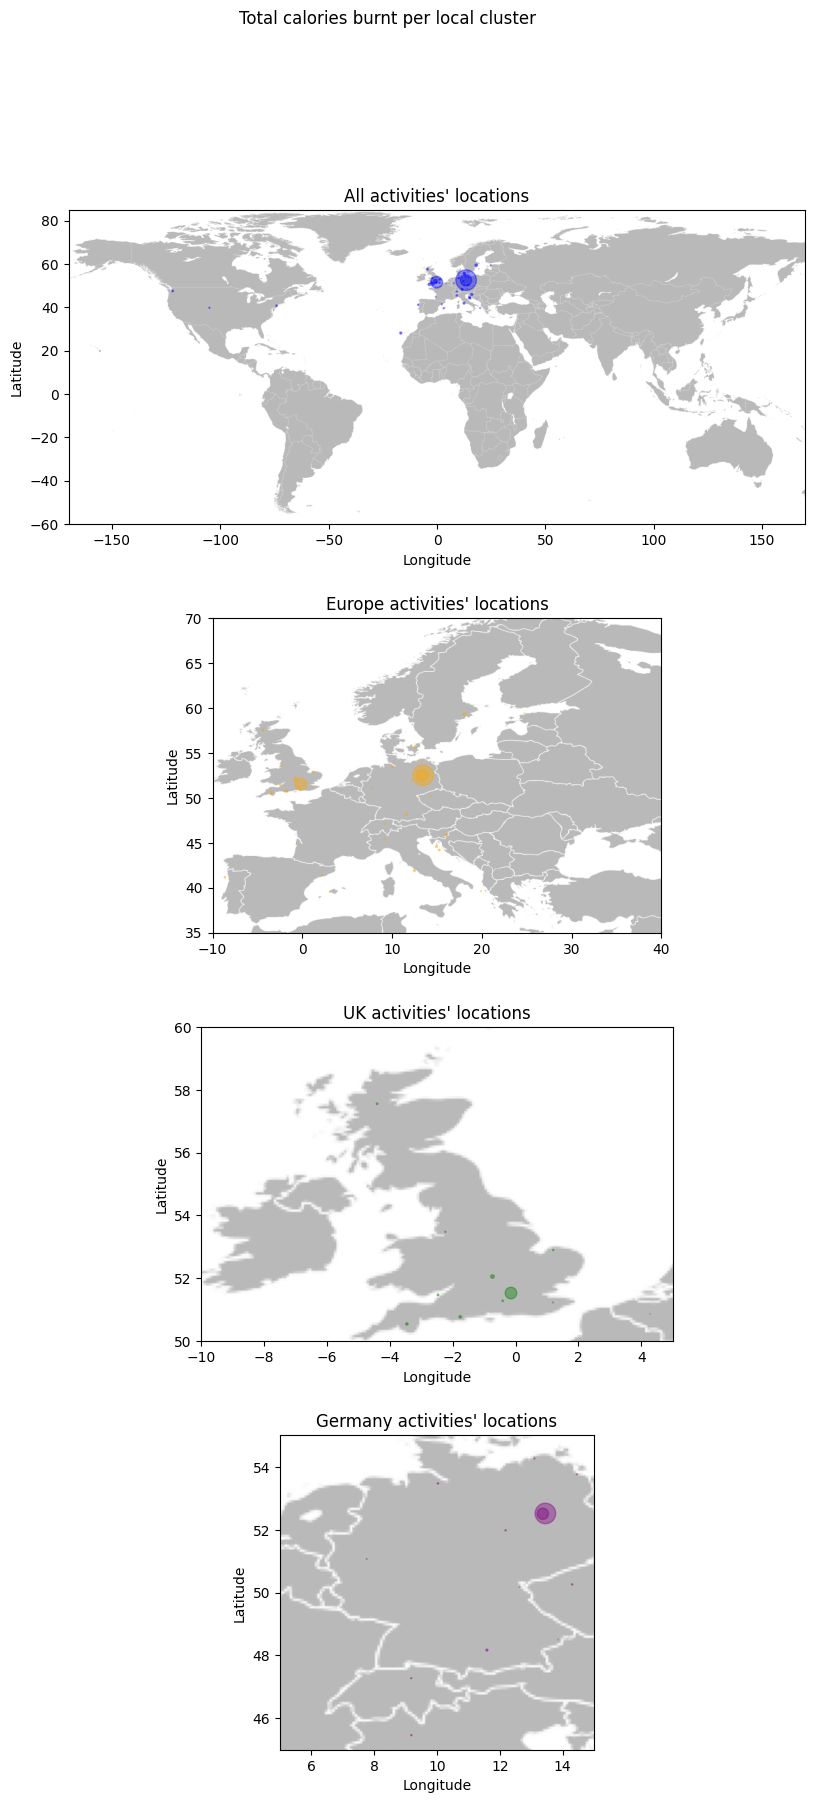

In [53]:
def plot_clusters_calories_burnt(ax, cluster_calories_frame, x_limits, y_limits, title, cluster_locations_frame, colour):
    cluster_calories_frame['longitude'] = cluster_locations_frame['longitude']
    cluster_calories_frame['latitude'] = cluster_locations_frame['latitude']
    ax.scatter(
        x=cluster_calories_frame['longitude'], 
        y=cluster_calories_frame['latitude'], 
        alpha=0.4,
        s=cluster_calories_frame['calories_burned']/1000,
        c=colour)
    ax.set_title(title)
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    apply_world_image_backdrop(ax)

def plot_all_regions_clusters_calories_burnt(cluster_calories_frame, cluster_locations_frame, figure_title):
    fig, axes = plt.subplots(len(map_regions), 1, figsize=(40, 20))
    for index, (title, (x_limits, y_limits, colour)) in enumerate(map_regions.items()):
        plot_clusters_calories_burnt(axes[index], cluster_calories_frame, x_limits, y_limits, title, cluster_locations_frame, colour)
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(figure_title)
    plt.show()

def plot_all_regions_local_clusters_calories_burnt():
    local_cluster_calories_frame = activity_frame.groupby('location_local_cluster').agg({'calories_burned': 'sum'})
    plot_all_regions_clusters_calories_burnt(local_cluster_calories_frame, local_cluster_locations_frame, 'Total calories burnt per local cluster')

plot_all_regions_local_clusters_calories_burnt()

Again for global cluster granularity:

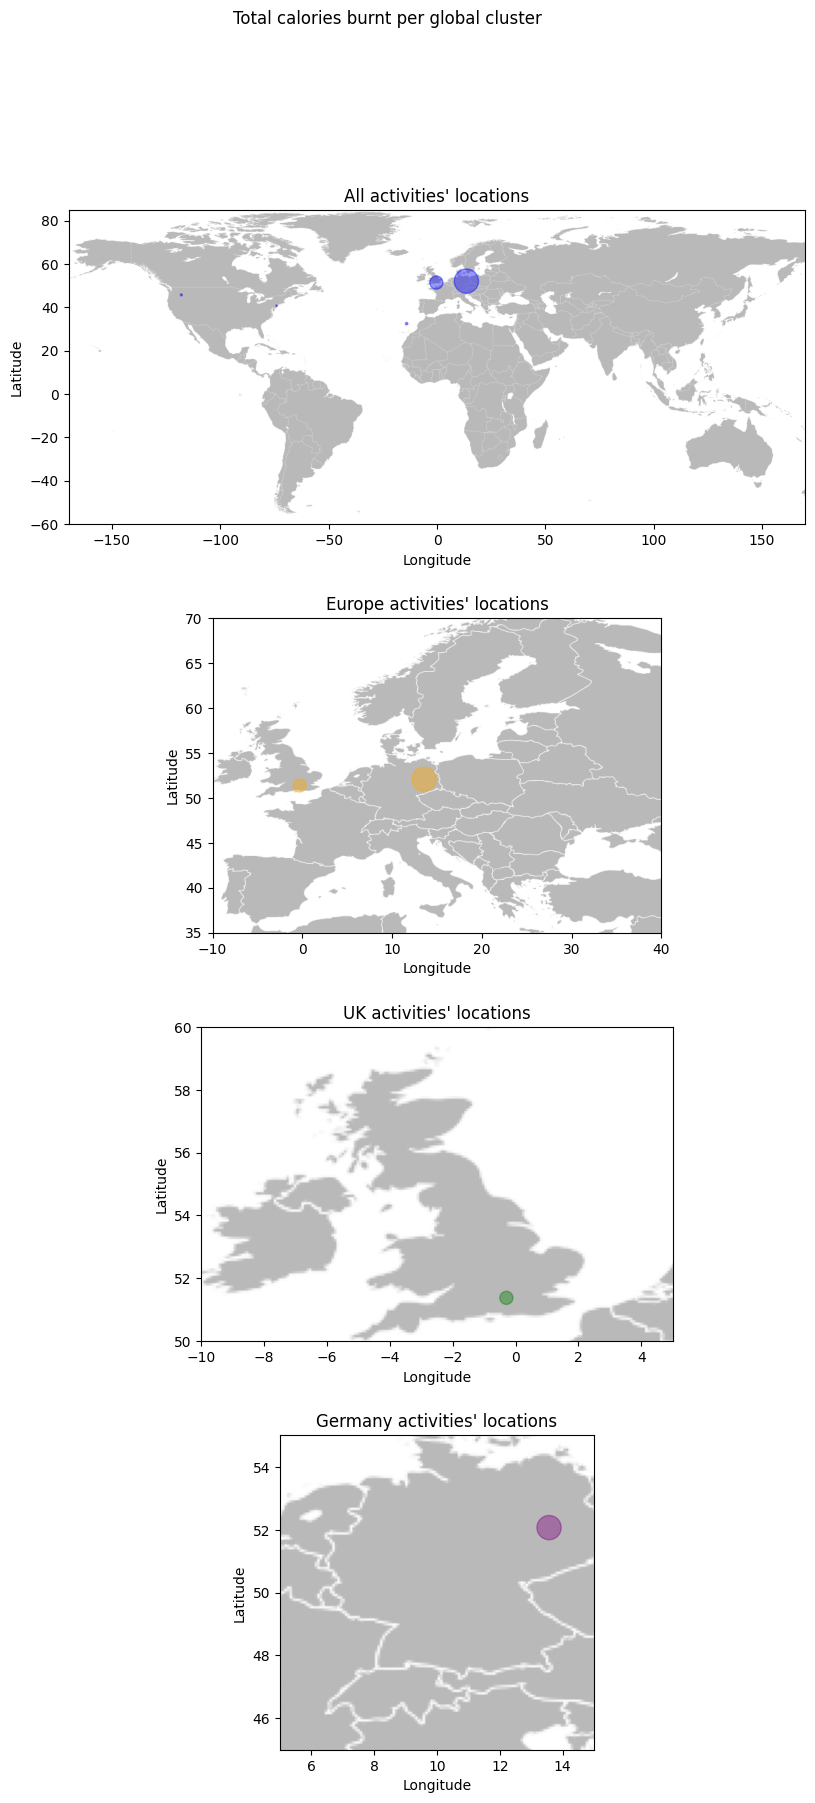

In [54]:
def plot_all_regions_global_clusters_calories_burnt():
    global_cluster_calories_frame = activity_frame.groupby('location_global_cluster').agg({'calories_burned': 'sum'})
    plot_all_regions_clusters_calories_burnt(global_cluster_calories_frame, global_cluster_locations_frame, 'Total calories burnt per global cluster')

plot_all_regions_global_clusters_calories_burnt()